In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [296]:
df = pd.read_csv('/content/world_development.csv')

In [297]:
df.head()

Country Name Country Code  \
0    Argentina          ARG   
1    Argentina          ARG   
2    Argentina          ARG   
3    Argentina          ARG   
4    Argentina          ARG   

                                         Series Name     Series Code  \
0  Adolescent fertility rate (births per 1,000 wo...     SP.ADO.TFRT   
1  Agriculture, forestry, and fishing, value adde...  NV.AGR.TOTL.ZS   
2  Annual freshwater withdrawals, total (% of int...  ER.H2O.FWTL.ZS   
3  Births attended by skilled health staff (% of ...  SH.STA.BRTC.ZS   
4  Contraceptive prevalence, any method (% of mar...  SP.DYN.CONU.ZS   

             YR2014            YR2015            YR2016            YR2017  \
0            66.613            63.879             58.79            55.022   
1  6.71270351428559   5.1566859021408  6.26456582010254  5.23162237725058   
2  12.9075342465753  12.9075342465753  12.9075342465753  12.9075342465753   
3              99.6              99.6              98.4              93.9   
4                ..                ..                ..                ..   

             YR2018            YR2019            YR2020            YR2021  \
0            49.926            41.751            31.492             28.54   
1  4.53787889681146   5.3185559967348  6.35703367575527  7.29128249622041   
2  12.9075342465753  12.9075342465753  12.9075342465753  12.9075342465753   
3              99.5              99.6              98.8                ..   
4                ..                ..              70.1                ..   

             YR2022             R2023  
0            25.767                ..  
1  6.63829697473642  5.92985376183283  
2                ..                ..  
3                ..                ..  
4                ..                ..

In [298]:
#Columns in Origional DF
df.columns

Index(['Country Name', 'Country Code', 'Series Name', 'Series Code', 'YR2014',
       'YR2015', 'YR2016', 'YR2017', 'YR2018', 'YR2019', 'YR2020', 'YR2021',
       'YR2022', 'R2023'],
      dtype='object')

In [299]:
#Unique Series
seriesUniques = df['Series Name'].unique()
print(seriesUniques)
print(len(seriesUniques))

['Adolescent fertility rate (births per 1,000 women ages 15-19)'
 'Agriculture, forestry, and fishing, value added (% of GDP)'
 'Annual freshwater withdrawals, total (% of internal resources)'
 'Births attended by skilled health staff (% of total)'
 'Contraceptive prevalence, any method (% of married women ages 15-49)'
 'Domestic credit provided by financial sector (% of GDP)'
 'Electric power consumption (kWh per capita)'
 'Energy use (kg of oil equivalent per capita)'
 'Exports of goods and services (% of GDP)'
 'External debt stocks, total (DOD, current US$)'
 'Fertility rate, total (births per woman)'
 'Foreign direct investment, net inflows (BoP, current US$)'
 'Forest area (sq. km)' 'GDP (current US$)' 'GDP growth (annual %)'
 'GNI per capita, Atlas method (current US$)'
 'GNI per capita, PPP (current international $)'
 'GNI, Atlas method (current US$)' 'GNI, PPP (current international $)'
 'Gross capital formation (% of GDP)'
 'High-technology exports (% of manufactured exports)

In [300]:
# Missing Values Currently expressed as '..' or '...' replace them with np.nan
df.replace(["..", "..."], np.nan, inplace=True)

# Identifying Usability of Years (Ie how much missing data)
print(df.isna().sum())
print(df.shape)

Country Name      0
Country Code      0
Series Name       0
Series Code       0
YR2014          161
YR2015          182
YR2016          165
YR2017          168
YR2018          161
YR2019          173
YR2020          196
YR2021          228
YR2022          306
R2023           607
dtype: int64
(1060, 14)


### NOTE : Determined that too much data is missing from year 2023 to include in model

In [301]:
# Reformating Data

# Melt the DataFrame to have 'Year' as a single column - to facilitate easier analysis
#Drop column 23 before reformatting
df_dropped23 = df.drop(columns=['R2023'])
print(df_dropped23.columns)
for col in df_dropped23.filter(like="YR").columns:
  df_dropped23[col] = df_dropped23[col].astype(float)


df_melted = df_dropped23.melt(id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
                    var_name="Year", value_name="Value")

df_melted["Year"] = df_melted["Year"].str.extract("(\d+)").astype(int)



df_pivoted = df_melted.pivot_table(index=["Country Name", "Country Code", "Year"],
                                   columns="Series Name", values="Value").reset_index()

# Rename GDP column
gdp_column_name = "GDP growth (annual %)"  # Update based on actual name
df_pivoted = df_pivoted.rename(columns={gdp_column_name: "GDP growth (annual %)"})

# Keep only necessary columns
df_final = df_pivoted[["Country Name", "Country Code", "Year", "GDP growth (annual %)"] + [col for col in df_pivoted.columns if col not in ["GDP growth (annual %)", "Country Name", "Year", "Country Code"]]]
df_final.head()

Index(['Country Name', 'Country Code', 'Series Name', 'Series Code', 'YR2014',
       'YR2015', 'YR2016', 'YR2017', 'YR2018', 'YR2019', 'YR2020', 'YR2021',
       'YR2022'],
      dtype='object')


Series Name Country Name Country Code  Year  GDP growth (annual %)  \
0              Argentina          ARG  2014              -2.512615   
1              Argentina          ARG  2015               2.731160   
2              Argentina          ARG  2016              -2.080328   
3              Argentina          ARG  2017               2.818503   
4              Argentina          ARG  2018              -2.617396   

Series Name  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                                       66.613               
1                                                       63.879               
2                                                       58.790               
3                                                       55.022               
4                                                       49.926               

Series Name  Agriculture, forestry, and fishing, value added (% of GDP)  \
0                                                     6.712704            
1                                                     5.156686            
2                                                     6.264566            
3                                                     5.231622            
4                                                     4.537879            

Series Name  Annual freshwater withdrawals, total (% of internal resources)  \
0                                                    12.907534                
1                                                    12.907534                
2                                                    12.907534                
3                                                    12.907534                
4                                                    12.907534                

Series Name  Births attended by skilled health staff (% of total)  \
0                                                         99.6      
1                                                         99.6      
2                                                         98.4      
3                                                         93.9      
4                                                         99.5      

Series Name  Contraceptive prevalence, any method (% of married women ages 15-49)  \
0                                                          NaN                      
1                                                          NaN                      
2                                                          NaN                      
3                                                          NaN                      
4                                                          NaN                      

Series Name  Domestic credit provided by financial sector (% of GDP)  ...  \
0                                                    34.432140        ...   
1                                                    40.427628        ...   
2                                                    37.932248        ...   
3                                                    38.868398        ...   
4                                                          NaN        ...   

Series Name  Revenue, excluding grants (% of GDP)  \
0                                       22.332294   
1                                       22.149080   
2                                       21.256701   
3                                       19.337124   
4                                       17.702448   

Series Name  School enrollment, primary (% gross)  \
0                                      113.961884   
1                                      113.778198   
2                                      112.944267   
3                                      111.681458   
4                                      111.545609   

Series Name  School enrollment, primary and secondary (gross), gender parity index (GPI)  \
0                                                      1.03123   

# Data Visualization & Exploration

In [302]:
# Filter the dataset for GDP growth indicator
gdp_growth_df = df[df["Series Name"] == "GDP growth (annual %)"]
gdp_growth_df.head()

Country Name Country Code            Series Name        Series Code  \
14     Argentina          ARG  GDP growth (annual %)  NY.GDP.MKTP.KD.ZG   
67     Australia          AUS  GDP growth (annual %)  NY.GDP.MKTP.KD.ZG   
120       Brazil          BRA  GDP growth (annual %)  NY.GDP.MKTP.KD.ZG   
173        China          CHN  GDP growth (annual %)  NY.GDP.MKTP.KD.ZG   
226       France          FRA  GDP growth (annual %)  NY.GDP.MKTP.KD.ZG   

                YR2014             YR2015             YR2016  \
14   -2.51261532081394   2.73115982828944  -2.08032784377811   
67    2.59528411594042   2.19016928695221    2.7593859723839   
120  0.503955740242247  -3.54576339269425  -3.27591690782192   
173   7.42576365632412   7.04132887873656   6.84876220495761   
226  0.997832937998666   1.06675473488909  0.860031082016107   

               YR2017             YR2018             YR2019  \
14   2.81850297775918  -2.61739646282038  -2.00086100285785   
67   2.27959179820343   2.87846971467883   2.17154505737176   
120  1.32286905404399     1.783666761634   1.22077782360842   
173  6.94720079331685    6.7497738324959   5.95050075367413   
226  2.08361485062076   1.64590872932709   2.02744647639635   

                 YR2020            YR2021            YR2022              R2023  
14     -9.9004848136464  10.4418119882506  5.26987967384072  -1.61100162090189  
67   -0.119590735829973  2.11116814768786  4.24238555336139   3.44199220009025  
120    -3.2767587964736  4.76260437908608  3.01669435393015   2.90848048667777  
173    2.23863835634639  8.44846941687277  2.95066992959268   5.24955786387791  
226   -7.44064593044142  6.88233786590355  2.57084047443969  0.936487502671483

In [303]:
# Set up for visualizations
gdp_growth_pivot = gdp_growth_df.set_index("Country Name")["YR2019"]
gdp_growth_pivot.head()


Country Name
Argentina    -2.00086100285785
Australia     2.17154505737176
Brazil        1.22077782360842
China         5.95050075367413
France        2.02744647639635
Name: YR2019, dtype: object

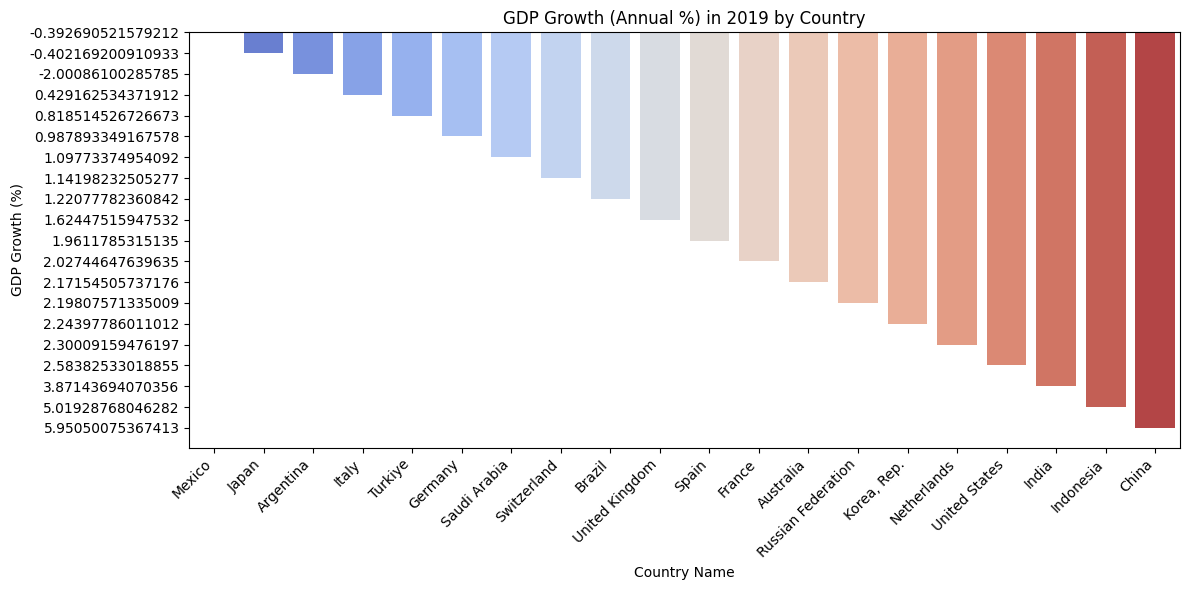

In [304]:
# Heatmap for GDP growth in 2019
plt.figure(figsize=(12, 6))
gdp_2019 = gdp_growth_df[["Country Name", "YR2019"]].dropna().set_index("Country Name")
gdp_2019_sorted = gdp_2019.sort_values(by="YR2019", ascending=True)

sns.barplot(x=gdp_2019_sorted.index, y=gdp_2019_sorted["YR2019"], palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title("GDP Growth (Annual %) in 2019 by Country")
plt.ylabel("GDP Growth (%)")
plt.tight_layout()
plt.show()

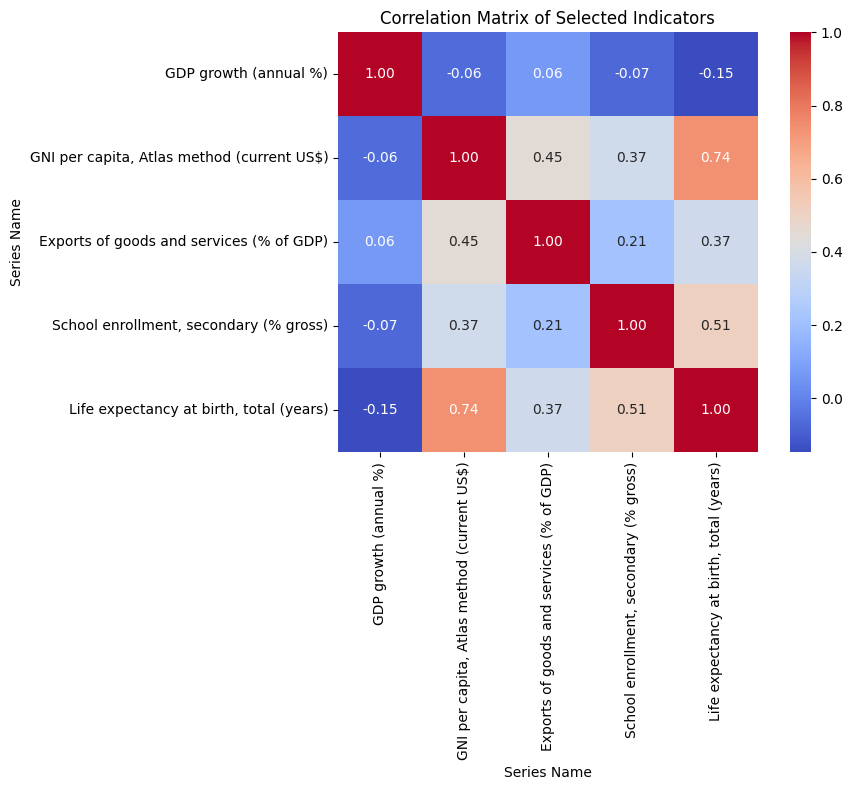

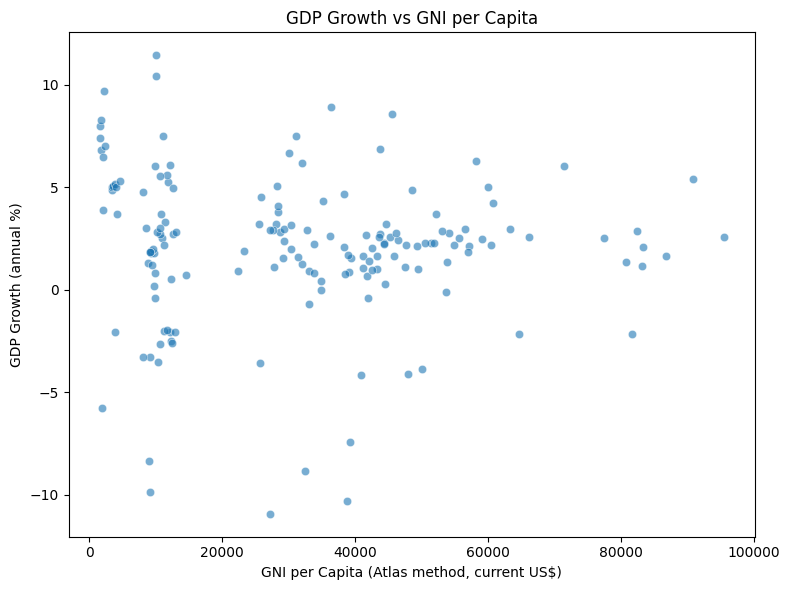

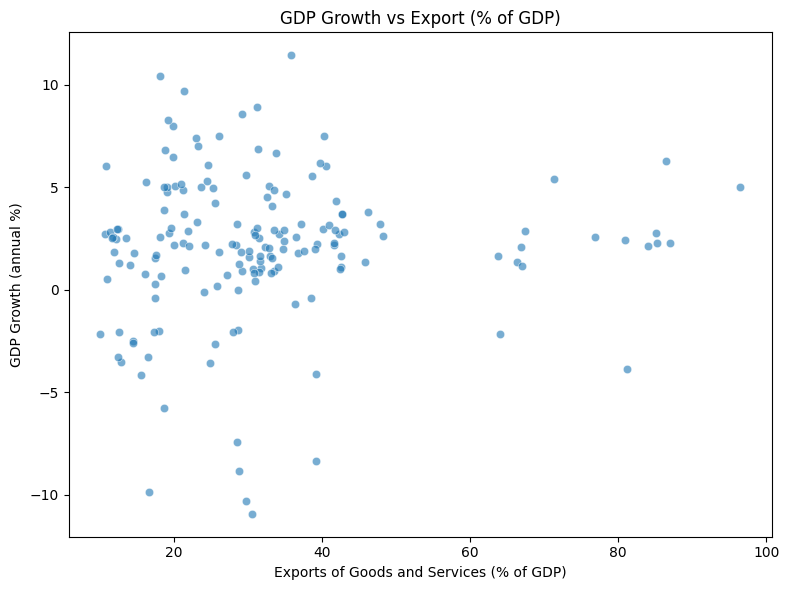

In [306]:
#Create Correlation Matrix of Selected Indicators for Data Visualization

# Corrected selected indicators with accurate names from dataset
selected_columns_corrected = [
    "GDP growth (annual %)",
    "GNI per capita, Atlas method (current US$)",
    "Exports of goods and services (% of GDP)",
    "School enrollment, secondary (% gross)",
    "Life expectancy at birth, total (years)"
]

# Filter pivoted dataframe for these indicators
filtered_df_pivot = df_pivot[selected_columns_corrected].dropna()

# Correlation matrix
corr_matrix_corrected = filtered_df_pivot.corr()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_corrected, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Selected Indicators")
plt.tight_layout()
plt.show()

# Scatterplot: GDP growth vs GNI per capita
plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_df_pivot,
                x="GNI per capita, Atlas method (current US$)",
                y="GDP growth (annual %)", alpha=0.6)
plt.title("GDP Growth vs GNI per Capita")
plt.xlabel("GNI per Capita (Atlas method, current US$)")
plt.ylabel("GDP Growth (annual %)")
plt.tight_layout()
plt.show()

# Scatterplot: GDP growth vs Exports of goods and services (% of GDP)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_df_pivot,
                x="Exports of goods and services (% of GDP)",
                y="GDP growth (annual %)", alpha=0.6)
plt.title("GDP Growth vs Export (% of GDP)")
plt.xlabel("Exports of Goods and Services (% of GDP)")
plt.ylabel("GDP Growth (annual %)")
plt.tight_layout()
plt.show()


In [307]:
#Create geo-maps to display data on a map

import plotly.express as px

# Select 3 indicators for geomapping
selected_indicators = [
    'Exports of goods and services (% of GDP)',
    'Gross capital formation (% of GDP)',
    'Electric power consumption (kWh per capita)'
]

# Filter dataset for the selected indicators
filtered_df = df[df['Series Name'].isin(selected_indicators)]

# Convert year columns to numeric, replacing ".." with NaN
year_columns = ['YR2014', 'R2023']
for col in year_columns:
    filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')

# Function to create a geomap for a specific year and indicator
def create_geomap(df, year, indicator):
    data = df[df['Series Name'] == indicator][['Country Name', 'Country Code', year]]
    fig = px.choropleth(
        data_frame=data,
        locations='Country Code',
        color=year,
        hover_name='Country Name',
        color_continuous_scale='Viridis',
        title=f'{indicator} - {year}'
    )
    fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
    return fig

# Create geomaps for each indicator for 2014 and 2023
geomaps = {}
for indicator in selected_indicators:
    geomaps[indicator] = {
        '2014': create_geomap(filtered_df, 'YR2014', indicator),
        '2023': create_geomap(filtered_df, 'R2023', indicator)
    }

# Show geomaps for the first indicator as example
geomaps[selected_indicators[0]]['2014'].show()
geomaps[selected_indicators[0]]['2023'].show()


In [308]:
geomaps[selected_indicators[1]]['2014'].show()
geomaps[selected_indicators[1]]['2023'].show()

In [309]:
#Count missing data
missing_counts = df_final.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
if not missing_counts.empty:
    print(missing_counts)

Series Name
Agriculture, forestry, and fishing, value added (% of GDP)                       1
Annual freshwater withdrawals, total (% of internal resources)                  20
Births attended by skilled health staff (% of total)                            88
Contraceptive prevalence, any method (% of married women ages 15-49)           154
Domestic credit provided by financial sector (% of GDP)                        127
Electric power consumption (kWh per capita)                                    155
Energy use (kg of oil equivalent per capita)                                   147
External debt stocks, total (DOD, current US$)                                 117
High-technology exports (% of manufactured exports)                              2
Income share held by lowest 20%                                                 48
Industry (including construction), value added (% of GDP)                        1
Mobile cellular subscriptions (per 100 people)                             

In [316]:
# Data Preprocessing - Data Cleaning Under Our Threshold

threshold = 0.1  # 10% threshold
df_cleaned = df_final.loc[:, df_final.isnull().mean() <= threshold]
df_cleaned = df_cleaned.drop(columns=['Country Code'])
df_cleaned = df_cleaned.drop(columns=['Revenue, excluding grants (% of GDP)'])
df_cleaned = df_cleaned.drop(columns=['School enrollment, secondary (% gross)'])

df_cleaned.loc[df_cleaned['Country Name'] == 'Japan', 'Tax revenue'] = 33

# Get the value of School_enrollment__primary for Netherlands in 2015
netherlands_2015_value = df_cleaned.loc[(df_cleaned['Country Name'] == 'Netherlands') & (df_cleaned['Year'] == 2015), 'School enrollment, primary (% gross)'].values[0]

# Set the value for Netherlands in 2014
df_cleaned.loc[(df_cleaned['Country Name'] == 'Netherlands') & (df_cleaned['Year'] == 2014), 'School enrollment, primary (% gross)'] = netherlands_2015_value

# For reamaining missing data use a forward fill
df_cleaned = df_cleaned.ffill()
print(f"Final Feature List with size of {df_cleaned.shape}:")
print(df_cleaned.columns)

Final Feature List with size of (180, 35):
Index(['Country Name', 'Year', 'GDP growth (annual %)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'Forest area (sq. km)', 'GDP (current US$)',
       'GNI per capita, Atlas method (current US$)',
       'GNI per capita, PPP (current international $)',
       'GNI, Atlas method (current US$)', 'GNI, PPP (current international $)',
       'Gross capital formation (% of GDP)',
       'High-technology exports (% of manufactured exports)',
       'Immunization, measles (% of children ages 12-23 months)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life

In [319]:
#Calculate GDP Increases Over Cleaned Data
def calculate_gdp_increase(df):
    """Calculates total and annual average GDP percentage increase for each country."""

    results = []

    # Convert 'Year' to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['Year']):
        df['Year'] = pd.to_datetime(df['Year'], format='%Y')

    # Group by country
    for country, country_data in df.groupby('Country Name'):
        # Filter for years 2014 and 2022
        gdp_2014 = country_data[country_data['Year'].dt.year == 2014]['GDP (current US$)'].values
        gdp_2022 = country_data[country_data['Year'].dt.year == 2022]['GDP (current US$)'].values

        if gdp_2014.size > 0 and gdp_2022.size > 0:
            gdp_2014 = gdp_2014[0]
            gdp_2022 = gdp_2022[0]

            # Calculate total percentage increase
            total_increase = ((gdp_2022 - gdp_2014) / gdp_2014) * 100

            # Calculate annual average percentage increase
            years_diff = 2022 - 2014
            annual_average_increase = total_increase / years_diff

            results.append({
                'Country': country,
                'Total % Increase': total_increase,
                'Annual Average % Increase': annual_average_increase
            })
        else:
            print(f"Missing GDP data for {country} in 2014 or 2022.")

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Print the chart
    print(results_df)

# Assuming df_cleaned is your DataFrame
calculate_gdp_increase(df_cleaned)

               Country  Total % Increase  Annual Average % Increase
0            Argentina         20.229226                   2.528653
1            Australia         15.160263                   1.895033
2               Brazil        -20.525684                  -2.565711
3                China         70.698959                   8.837370
4               France         -2.269435                  -0.283679
5              Germany          4.987534                   0.623442
6                India         64.456228                   8.057029
7            Indonesia         48.075260                   6.009408
8                Italy         -3.232918                  -0.404115
9                Japan        -13.081159                  -1.635145
10         Korea, Rep.         12.760488                   1.595061
11              Mexico          7.314358                   0.914295
12         Netherlands         16.081554                   2.010194
13  Russian Federation         10.041933        

In [351]:
import plotly.express as px
import pandas as pd

def create_gdp_geomap(df_cleaned, year):
    """
    Creates a choropleth map of GDP for a given year using Plotly Express.

    Args:
        df_cleaned (pd.DataFrame): The cleaned DataFrame containing country data, including 'Country_Name', 'Year', and 'GDP'.
        year (int): The year for which to create the map.
    """

    # Convert 'Year' to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df_cleaned['Year']):
        df_cleaned['Year'] = pd.to_datetime(df_cleaned['Year'], format='%Y')

    # Filter the DataFrame for the specified year
    df_year = df_cleaned[df_cleaned['Year'].dt.year == year]

    if df_year.empty:
        print(f"No data available for the year {year}.")
        return

    # Create the choropleth map
    fig = px.choropleth(
        df_year,
        locations='Country_Name',  # Column with country names
        locationmode='country names',  # Ensure country names are correctly matched
        color='GDP',  # Column with GDP values
        hover_name='Country_Name',  # Column to display on hover
        title=f'GDP (current US$) for {year}',
        color_continuous_scale=px.colors.sequential.Plasma,
    )

    fig.show()

# Example usage (assuming your cleaned DataFrame is named 'df_cleaned'):
create_gdp_geomap(df_cleaned, 2015)
create_gdp_geomap(df_cleaned, 2022)

In [326]:
# Multiple Regression - Data Analysis

columns_to_drop = [
    "Contraceptive prevalence, any method (% of married women ages 15-49)",
    "Domestic credit provided by financial sector (% of GDP)",
    "Electric power consumption (kWh per capita)",
    "Energy use (kg of oil equivalent per capita)",
    "External debt stocks, total (DOD, current US$)",
    "Net official development assistance and official aid received (current US$)",
    "Prevalence of underweight, weight for age (% of children under 5)"
]

df_multReg = df_final.drop(columns=columns_to_drop)

#df_multReg = df_cleaned.copy
numeric_cols = df_multReg.select_dtypes(include=[np.number]).columns
df_multReg[numeric_cols] = df_multReg[numeric_cols].fillna(df_multReg[numeric_cols].mean())

def run_multReg(df, target, independent_cols):
    X = df[independent_cols]
    y = df[target]

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    return model

def model_summary(model):
    print("\nModel Summary:")
    print(model.summary())

    y_pred = model.fittedvalues
    y_actual = model.model.endog

    print("\nMetrics:")
    print("MAE:", mean_absolute_error(y_actual, y_pred))
    print("MSE:", mean_squared_error(y_actual, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_actual, y_pred)))
    print("R²:", r2_score(y_actual, y_pred))



independent_cols = df_multReg.columns.drop(["Country Name", "Country Code", "Year", "GDP growth (annual %)"]).tolist()
model = run_multReg(df_multReg, "GDP growth (annual %)", independent_cols)
model_summary(model)


Model Summary:
                              OLS Regression Results                             
Dep. Variable:     GDP growth (annual %)   R-squared:                       0.406
Model:                               OLS   Adj. R-squared:                  0.235
Method:                    Least Squares   F-statistic:                     2.373
Date:                   Mon, 17 Mar 2025   Prob (F-statistic):           0.000114
Time:                           05:58:53   Log-Likelihood:                -440.60
No. Observations:                    180   AIC:                             963.2
Df Residuals:                        139   BIC:                             1094.
Df Model:                             40                                         
Covariance Type:               nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------

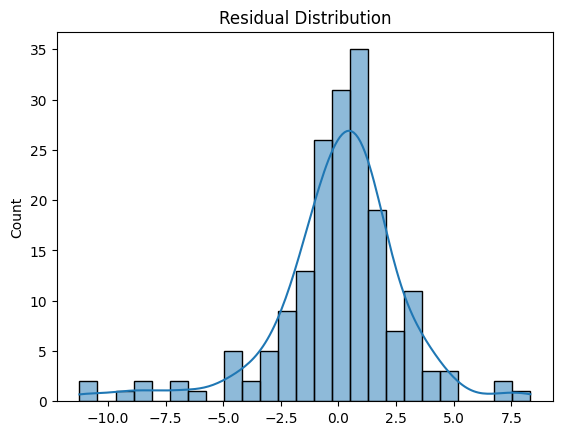

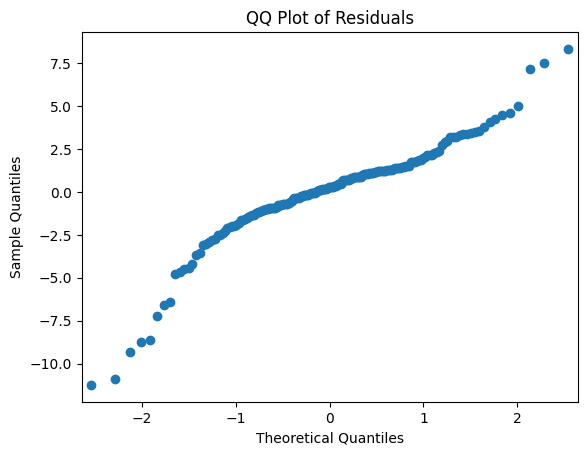

In [327]:
residuals = model.resid
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()
sm.qqplot(residuals)
plt.title("QQ Plot of Residuals")
plt.show()

In [328]:
def calculate_vif(df, independent_cols):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = independent_cols
    vif_data["VIF"] = [variance_inflation_factor(df[independent_cols].values, i) for i in range(len(independent_cols))]
    print("\nCalculated VIF:\n", vif_data)
vif_df = calculate_vif(df_multReg, independent_cols)


Calculated VIF:
                                               Feature          VIF
0   Adolescent fertility rate (births per 1,000 wo...    28.466013
1   Agriculture, forestry, and fishing, value adde...    56.195197
2   Annual freshwater withdrawals, total (% of int...    17.715456
3   Births attended by skilled health staff (% of ...     1.964667
4            Exports of goods and services (% of GDP)   294.943660
5            Fertility rate, total (births per woman)    17.369425
6   Foreign direct investment, net inflows (BoP, c...     2.802523
7                                Forest area (sq. km)   136.339631
8                                   GDP (current US$)  1150.298914
9          GNI per capita, Atlas method (current US$)    80.255731
10      GNI per capita, PPP (current international $)    64.315612
11                    GNI, Atlas method (current US$)  1384.265052
12                 GNI, PPP (current international $)   315.367375
13                 Gross capital formation (

In [329]:
def remove_high_vif(df, independent_cols, threshold=10):
    while True:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = independent_cols
        vif_data["VIF"] = [variance_inflation_factor(df[independent_cols].values, i) for i in range(len(independent_cols))]

        max_vif = vif_data["VIF"].max()
        if max_vif < threshold:
            break

        high_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        independent_cols.remove(high_vif_feature)

    return independent_cols

vif_cols = remove_high_vif(df_multReg, independent_cols)
print(vif_cols)


['Annual freshwater withdrawals, total (% of internal resources)', 'Births attended by skilled health staff (% of total)', 'Fertility rate, total (births per woman)', 'Foreign direct investment, net inflows (BoP, current US$)', 'Forest area (sq. km)', 'GDP (current US$)', 'GNI per capita, Atlas method (current US$)', 'Gross capital formation (% of GDP)', 'High-technology exports (% of manufactured exports)', 'Immunization, measles (% of children ages 12-23 months)', 'Income share held by lowest 20%', 'Inflation, GDP deflator (annual %)', 'Merchandise trade (% of GDP)', 'Mobile cellular subscriptions (per 100 people)', 'Net barter terms of trade index (2015 = 100)', 'Net migration', 'Personal remittances, received (current US$)', 'Population density (people per sq. km of land area)', 'Population growth (annual %)', 'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)', 'Poverty headcount ratio at national poverty lines (% of population)', 'Prevalence of HIV, total (% of 

In [330]:
model_vif = run_multReg(df_multReg, "GDP growth (annual %)", vif_cols)
model_summary(model_vif)



Model Summary:
                              OLS Regression Results                             
Dep. Variable:     GDP growth (annual %)   R-squared:                       0.350
Model:                               OLS   Adj. R-squared:                  0.225
Method:                    Least Squares   F-statistic:                     2.788
Date:                   Mon, 17 Mar 2025   Prob (F-statistic):           2.86e-05
Time:                           05:59:05   Log-Likelihood:                -448.65
No. Observations:                    180   AIC:                             957.3
Df Residuals:                        150   BIC:                             1053.
Df Model:                             29                                         
Covariance Type:               nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------

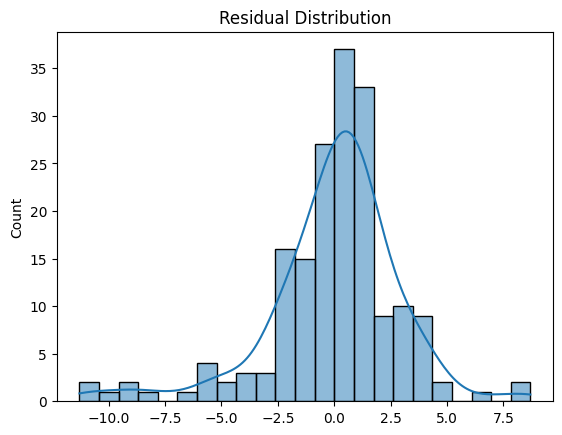

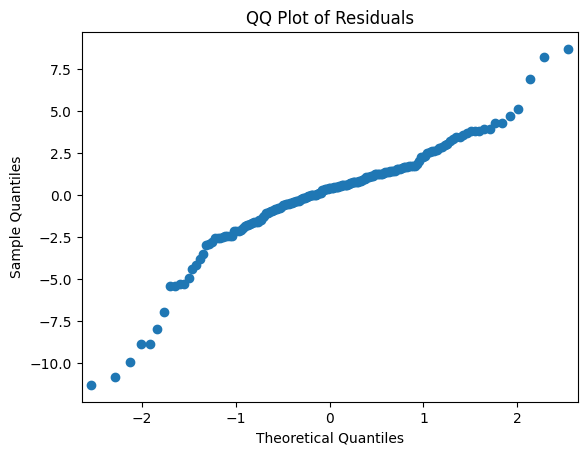

In [331]:
residuals = model_vif.resid
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()
sm.qqplot(residuals)
plt.title("QQ Plot of Residuals")
plt.show()

In [332]:
#reintroducing some features removed due to high VIF
add_cols = [
    "GDP (current US$)",
    "GNI per capita, Atlas method (current US$)",
    "Exports of goods and services (% of GDP)",
    "Forest area (sq. km)",
    "Tax revenue (% of GDP)"
]

new_cols = vif_cols + add_cols
new_df = calculate_vif(df_multReg, new_cols)
model_updated = run_multReg(df_multReg, "GDP growth (annual %)", new_cols)
model_summary(model_updated)



Calculated VIF:
                                               Feature           VIF
0   Annual freshwater withdrawals, total (% of int...  4.621485e+00
1   Births attended by skilled health staff (% of ...  1.157552e+00
2            Fertility rate, total (births per woman)  5.506477e+00
3   Foreign direct investment, net inflows (BoP, c...  2.429418e+00
4                                Forest area (sq. km)  3.354237e+07
5                                   GDP (current US$)           inf
6          GNI per capita, Atlas method (current US$)  1.114391e+10
7                  Gross capital formation (% of GDP)  4.758258e+00
8   High-technology exports (% of manufactured exp...  4.275447e+00
9   Immunization, measles (% of children ages 12-2...  2.308160e+00
10                    Income share held by lowest 20%  5.082956e+00
11                 Inflation, GDP deflator (annual %)  1.898135e+00
12                       Merchandise trade (% of GDP)  3.401598e+01
13     Mobile cellular subscri

In [333]:
# Cleaning Column Names For Stepwise Regression - Removing Unusual Characters
import re

def clean_column_names(df):
    cleaned_names = {}

    for col in df.columns:
        cleaned_name = re.sub(r" \(.*?\)|\[.*?\]", "", col)
        cleaned_name = re.sub(r"[^a-zA-Z0-9]", "_", cleaned_name)
        if not cleaned_name:
            cleaned_name = "unnamed_" + str(col)
        cleaned_names[col] = cleaned_name

    df = df.rename(columns=cleaned_names)

    return df

df_cleaned = clean_column_names(df_cleaned)

In [334]:
# Stepwise Regression - Data Analysis
df_stepReg = df_cleaned.copy()
print(df_stepReg.columns)
response = 'GDP_growth'

df_stepReg['GDP_growth'] = pd.to_numeric(df_stepReg['GDP_growth'], errors='coerce')
df_stepReg = df_stepReg.dropna(subset=['GDP_growth'])

def criterion(formula, df):
  model = smf.ols(formula, df).fit()
  # Switched from BIC which only produced 2 factors, produces better fit than adj R^2
  criterion_value = model.aic
  return criterion_value

def add(df, selected_columns, columns, criterion, response='y'):
  best_criterion = np.inf
  best_column = None

  for column in columns - selected_columns:
      new_columns = selected_columns.union({column})
      formula = f'{response} ~ {" + ".join(new_columns)}'
      current_criterion = criterion(formula, df)
      if current_criterion < best_criterion:
        best_criterion = current_criterion
        best_column = column
  return selected_columns.union({best_column}), best_criterion

def forward(df, criterion, response='y'):
  selected_columns = set()
  columns = set(df.columns.drop(response))
  best_criterion = np.inf
  while len(selected_columns) < len(columns):
    potential_columns, current_criterion = add(df, selected_columns, columns,
                                                  criterion, response)
    if current_criterion > best_criterion:
      break

    else:
      selected_columns = potential_columns
      best_criterion = current_criterion
      print(f'Criterion: {best_criterion}')
  return selected_columns


forward_vars = forward(df_stepReg, criterion, response)
print(forward_vars)
forward_formula = f"{response} ~ {' + '.join(forward_vars)}"
print(f'\nOptimal Formula Using Forward Selection: {forward_formula}')


Index(['Country_Name', 'Year', 'GDP_growth', 'Adolescent_fertility_rate',
       'Agriculture__forestry__and_fishing__value_added',
       'Exports_of_goods_and_services', 'Fertility_rate__total',
       'Foreign_direct_investment__net_inflows', 'Forest_area', 'GDP',
       'GNI_per_capita__Atlas_method', 'GNI_per_capita__PPP',
       'GNI__Atlas_method', 'GNI__PPP', 'Gross_capital_formation',
       'High_technology_exports', 'Immunization__measles',
       'Imports_of_goods_and_services', 'Industry__value_added',
       'Inflation__GDP_deflator', 'Life_expectancy_at_birth__total',
       'Merchandise_trade', 'Military_expenditure',
       'Mobile_cellular_subscriptions', 'Mortality_rate__under_5',
       'Net_migration', 'Personal_remittances__received', 'Population_density',
       'Population_growth', 'Population__total', 'School_enrollment__primary',
       'Surface_area', 'Tax_revenue', 'Urban_population_growth',
       'Tax_revenue'],
      dtype='object', name='Series Name')
Cr

In [335]:
# Model summary from forward + AIC
stepwise_model = smf.ols(forward_formula, df_stepReg).fit()
print(stepwise_model.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP_growth   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     13.03
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           3.62e-18
Time:                        05:59:27   Log-Likelihood:                -167.79
No. Observations:                  99   AIC:                             393.6
Df Residuals:                      70   BIC:                             468.8
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [336]:
# Stepwise regression with backward + BIC
def criterion(formula, df):
    model = smf.ols(formula, df).fit()
    criterion_value = model.bic
    return criterion_value

def remove(df, already_selected_columns, criterion, response='y'):
    worst_criterion = np.inf
    worst_column = None

    for column in already_selected_columns:
        new_columns = already_selected_columns - {column}
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column
    return worst_column, worst_criterion

def backward(df, criterion, response='y'):
    already_selected_columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(already_selected_columns) > 0:
        potential_column, current_criterion = remove(df, already_selected_columns, criterion, response)

        if current_criterion <= best_criterion:
            already_selected_columns = already_selected_columns - {potential_column}
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
        else:
            break
    final_selection = already_selected_columns
    return final_selection

backward_vars = backward(df_stepReg, criterion, response)
print(backward_vars)
backward_formula = f"{response} ~ {' + '.join(backward_vars)}"
print(f'\nOptimal Formula Using Backward Selection: {backward_formula}')

Criterion: 487.4074397173389
Criterion: 482.171799626197
Criterion: 479.2411400437045
Criterion: 476.34522733085316
Criterion: 474.6238935399331
Criterion: 469.98288583693574
Criterion: 465.6413988631539
{'Life_expectancy_at_birth__total', 'Urban_population_growth', 'High_technology_exports', 'Military_expenditure', 'GNI_per_capita__PPP', 'Mortality_rate__under_5', 'Gross_capital_formation', 'Forest_area', 'Population_growth', 'Inflation__GDP_deflator', 'Country_Name', 'Fertility_rate__total', 'Net_migration', 'Adolescent_fertility_rate', 'Personal_remittances__received', 'Industry__value_added', 'Tax_revenue', 'Population__total', 'School_enrollment__primary', 'Exports_of_goods_and_services', 'Immunization__measles', 'Population_density', 'Year', 'GNI__PPP', 'GNI__Atlas_method', 'GNI_per_capita__Atlas_method'}

Optimal Formula Using Backward Selection: GDP_growth ~ Life_expectancy_at_birth__total + Urban_population_growth + High_technology_exports + Military_expenditure + GNI_per_capi

In [337]:
stepwise_model = smf.ols(backward_formula, df_stepReg).fit()
print(stepwise_model.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP_growth   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     13.62
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           1.06e-18
Time:                        05:59:54   Log-Likelihood:                -163.89
No. Observations:                  99   AIC:                             387.8
Df Residuals:                      69   BIC:                             465.6
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [338]:
new_formula = f'{response} ~ Adolescent_fertility_rate + Fertility_rate__total + Inflation__GDP_deflator + Surface_area + Tax_revenue + Military_expenditure + Gross_capital_formation + Population_density + GNI__Atlas_method + Immunization__measles'
new_model = smf.ols(new_formula, df_stepReg).fit()
print(new_model.summary())


                            OLS Regression Results                            
Dep. Variable:             GDP_growth   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.084
Date:                Mon, 17 Mar 2025   Prob (F-statistic):              0.383
Time:                        05:59:57   Log-Likelihood:                -252.47
No. Observations:                  99   AIC:                             526.9
Df Residuals:                      88   BIC:                             555.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

# Data Forecasting - ARIMA Model

In [339]:
#Create a dictionary - Key: Country Name, Value: country df (data is only of key country)
country_dfs = {}
for country in df_cleaned['Country_Name'].unique():
    country_dfs[country] = df_cleaned[df_cleaned['Country_Name'] == country].copy()


In [340]:
# Create list of columns that Stepwise & Multiple Linear Regression Deemed Statistically Significant
columns_to_keep_HIGHSS = [
    'Country_Name',
    'Year',
    'GDP_growth',
    'Population__total',
    'Foreign_direct_investment__net_inflows',
    'Gross_capital_formation',
    'High_technology_exports',
    'Forest_area',
    'Inflation__GDP_deflator',
    'Net_migration'
]

# Create a copy of the DataFrame with only the specified columns
df_HighSS = df_cleaned[columns_to_keep_HIGHSS].copy()

country_dfs_HSS = {}
for country in df_HighSS['Country_Name'].unique():
    country_dfs_HSS[country] = df_HighSS[df_HighSS['Country_Name'] == country].copy()


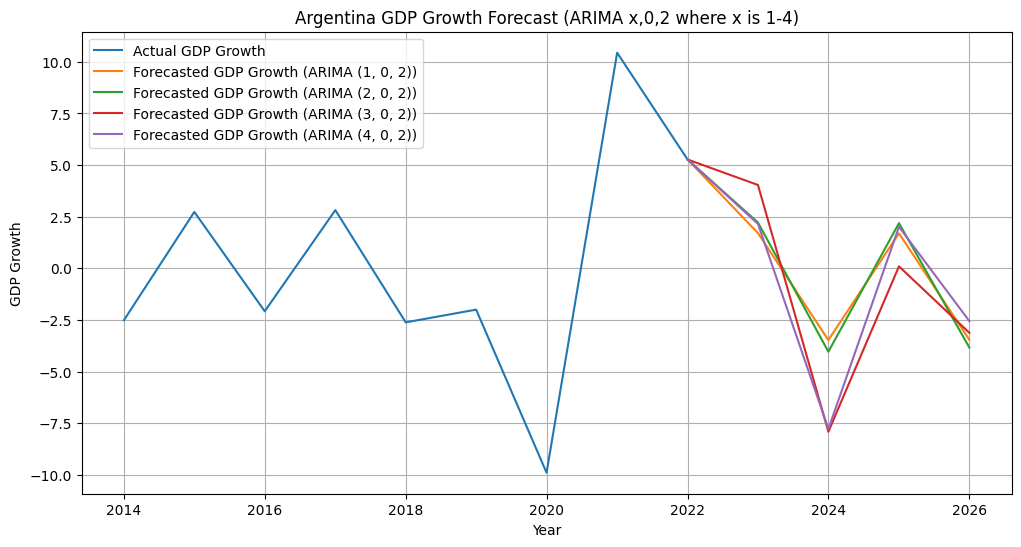

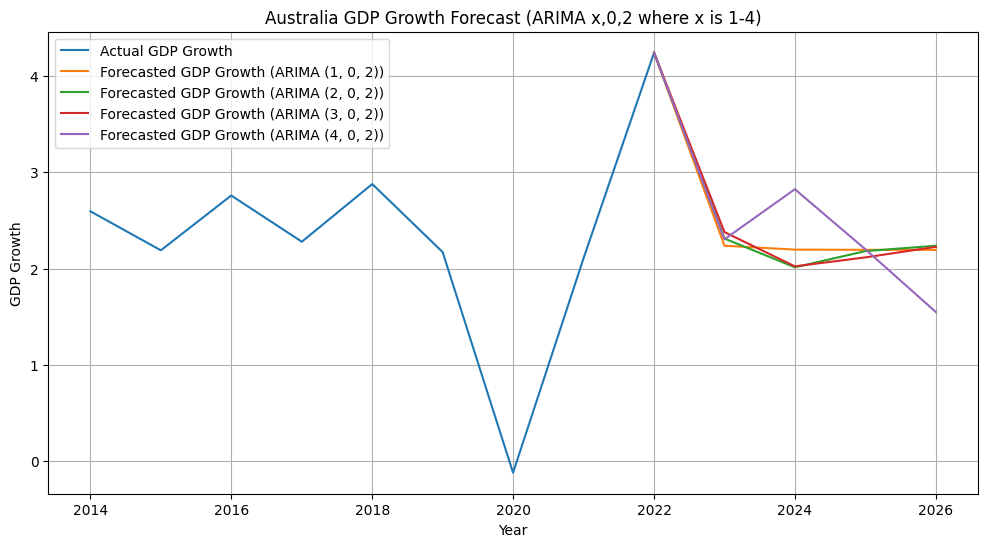

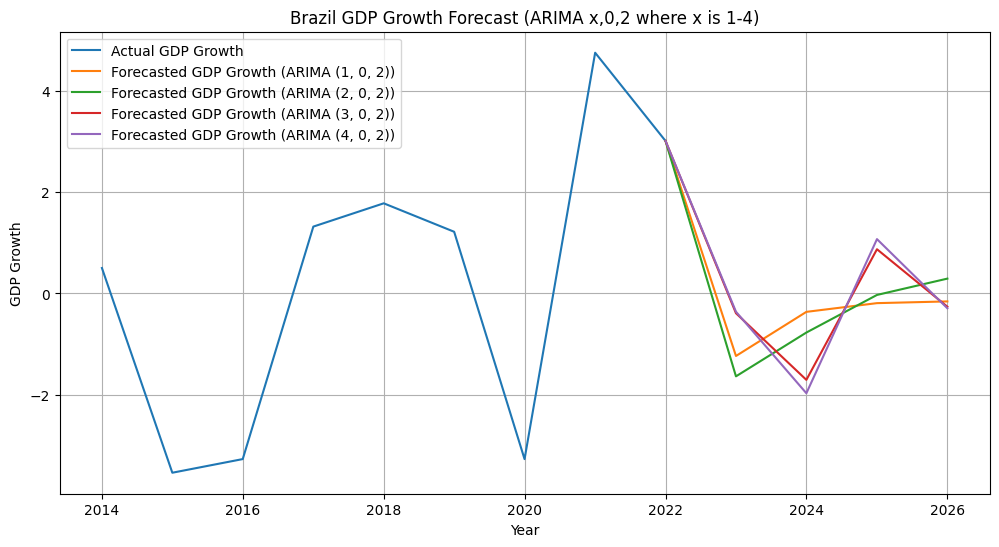

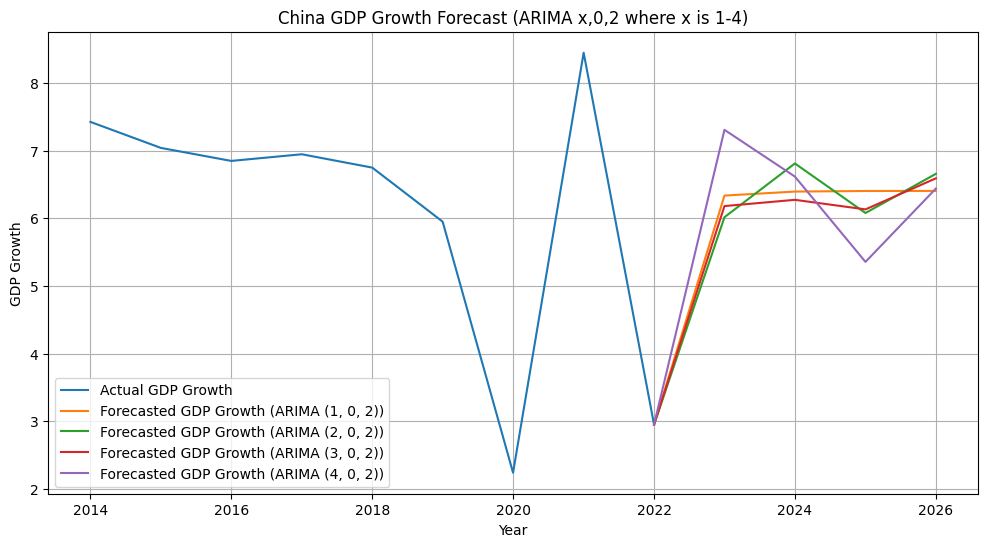

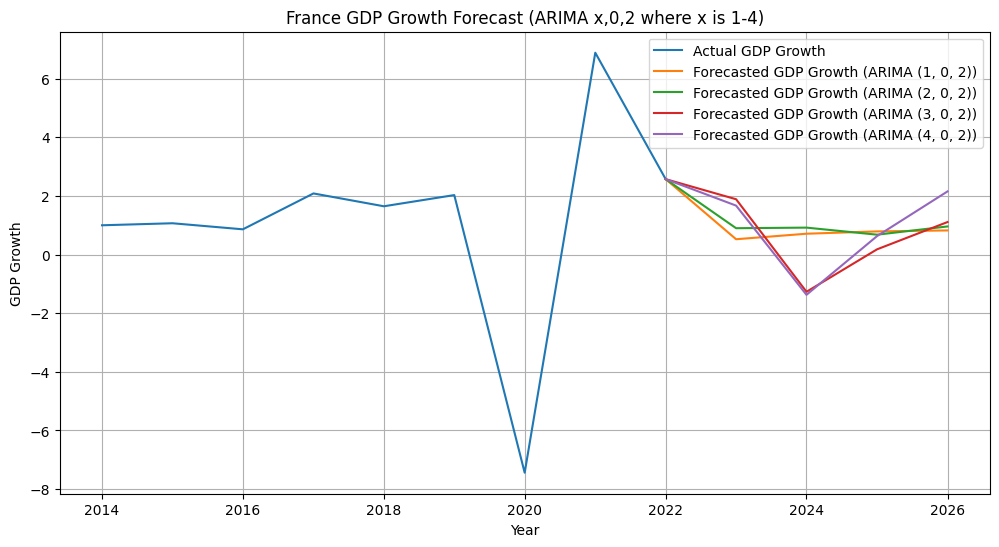

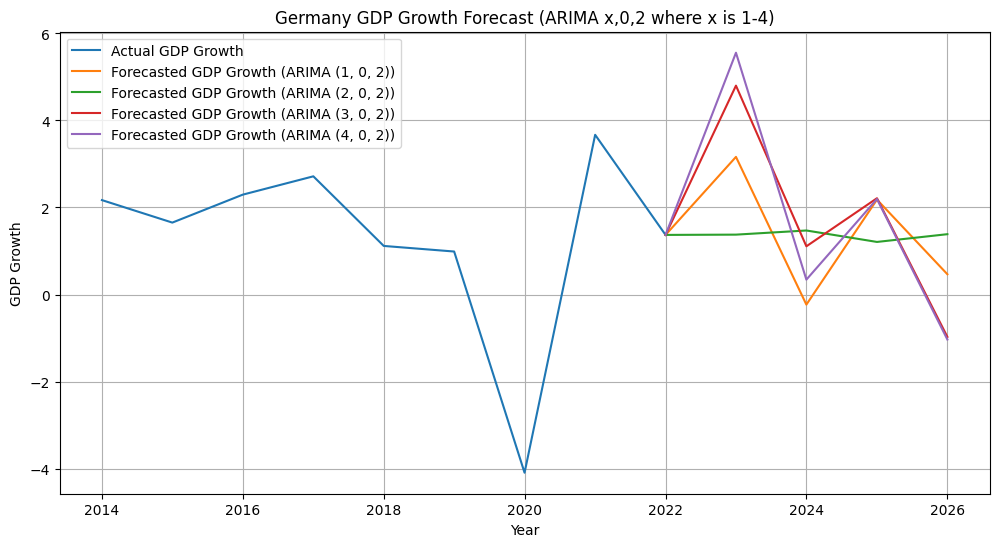

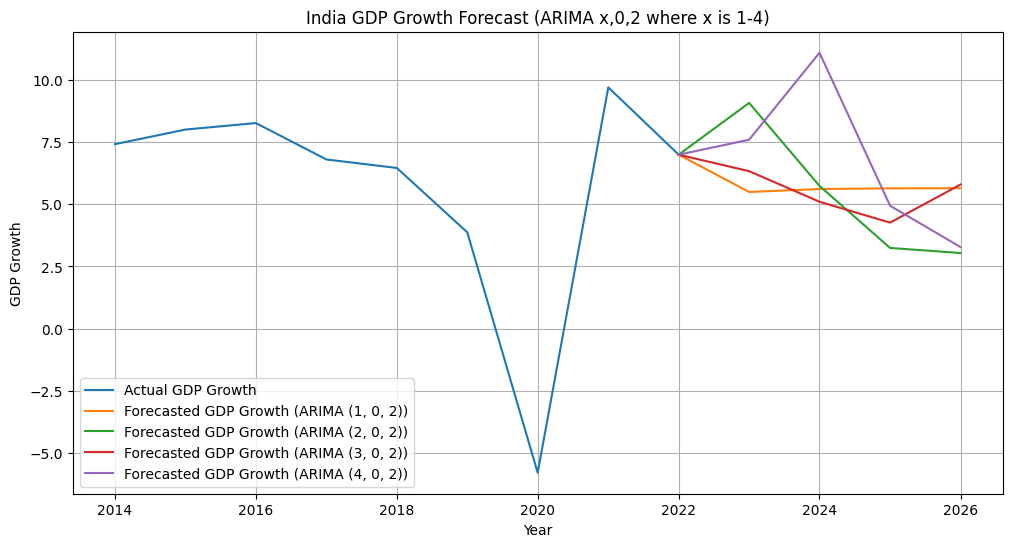

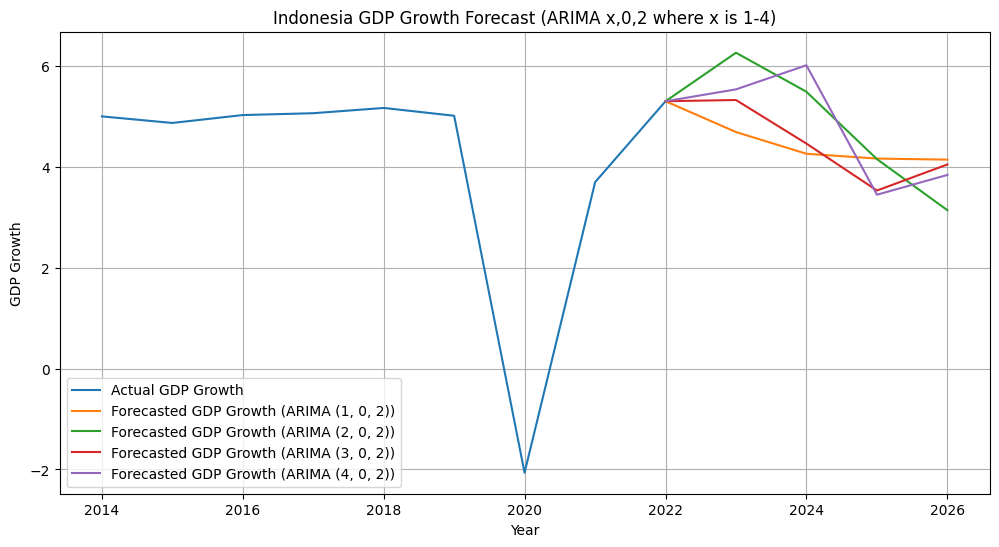

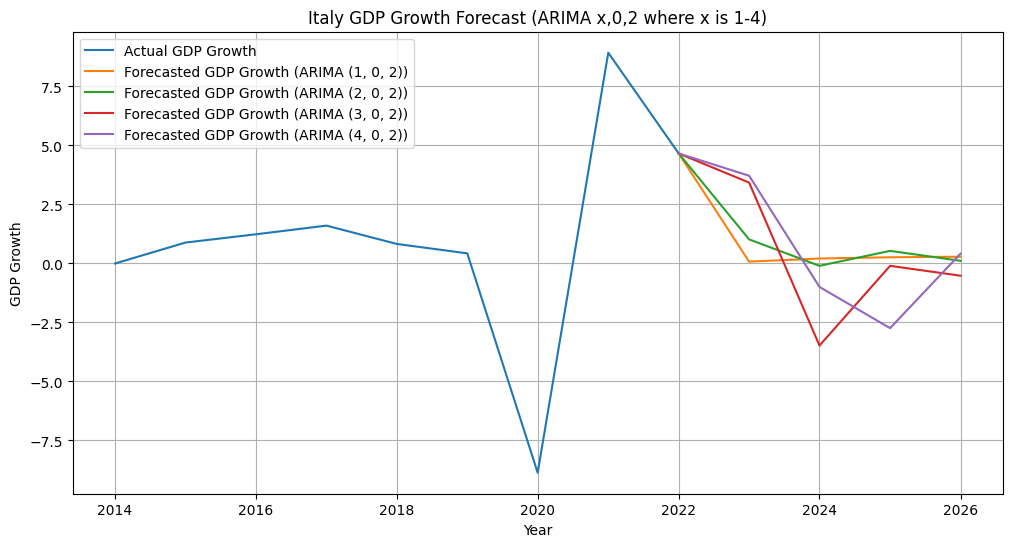

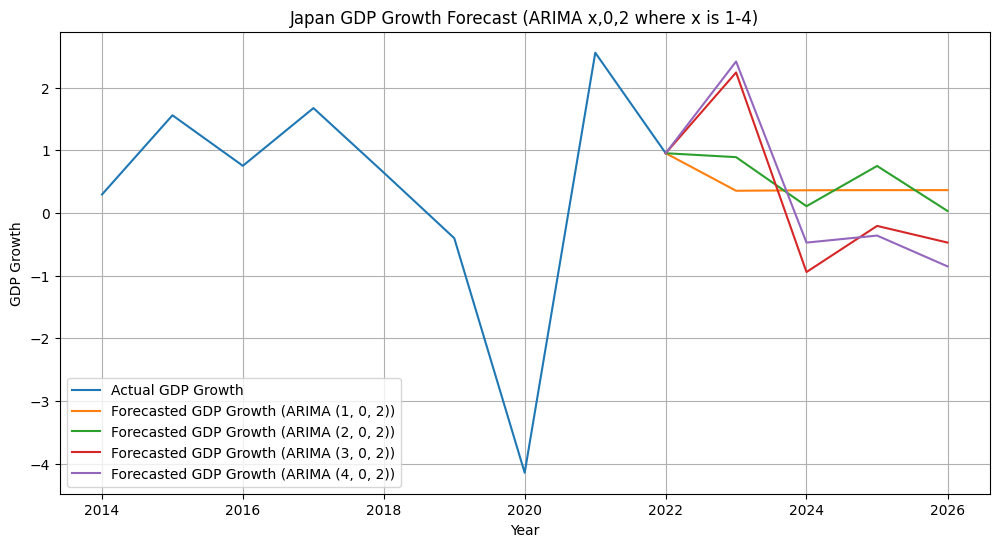

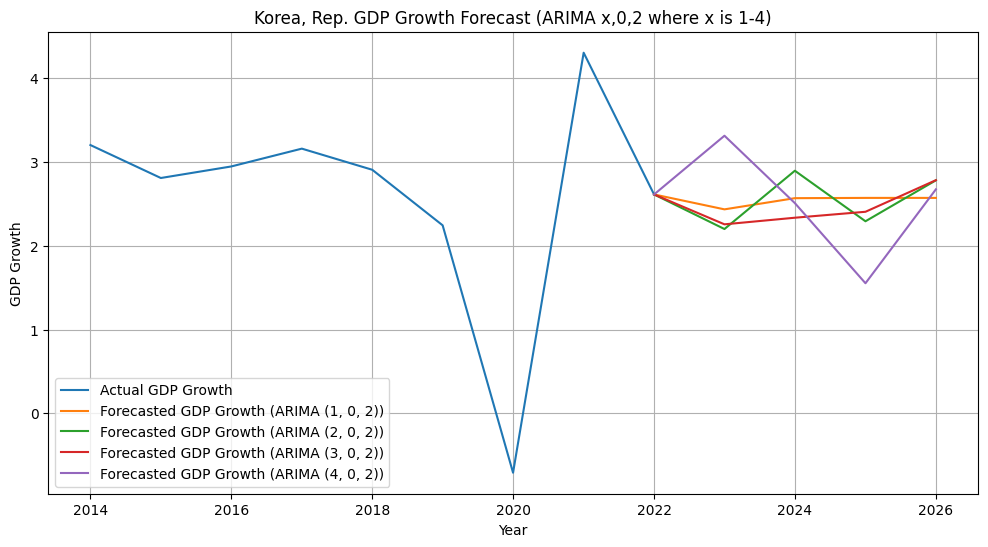

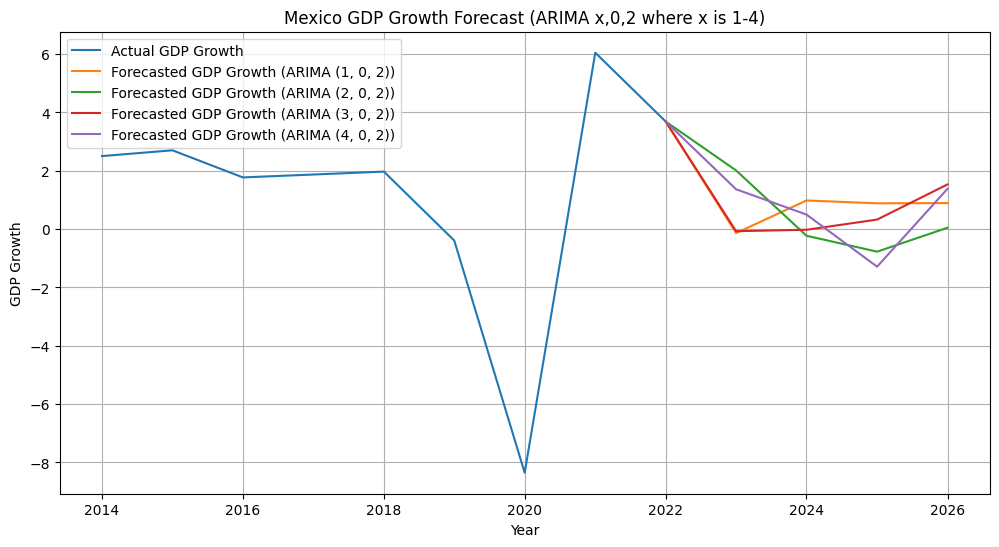

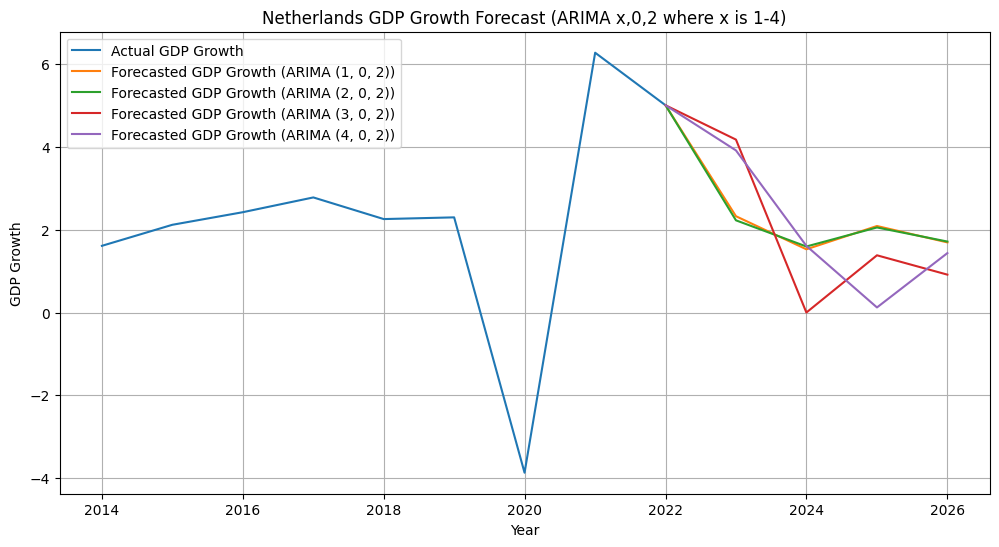

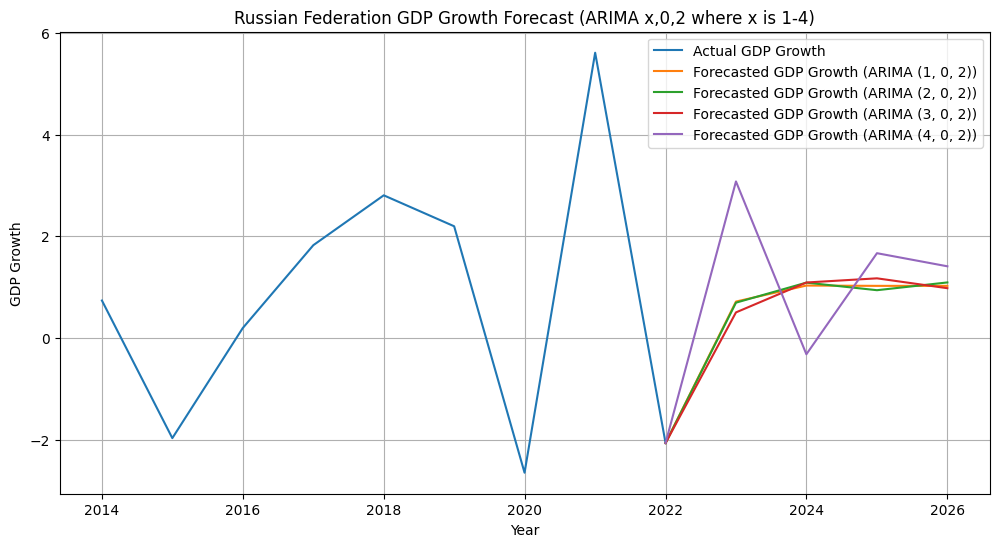

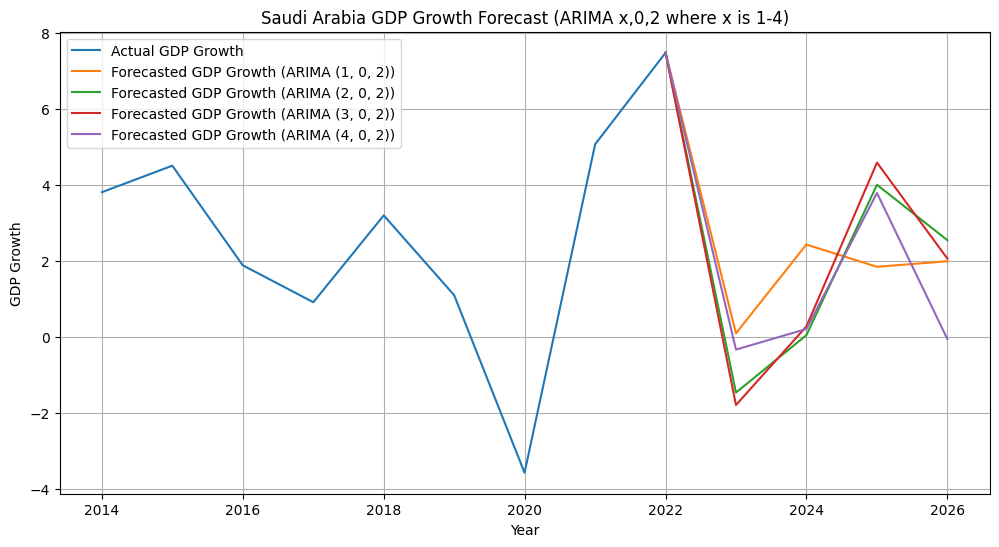

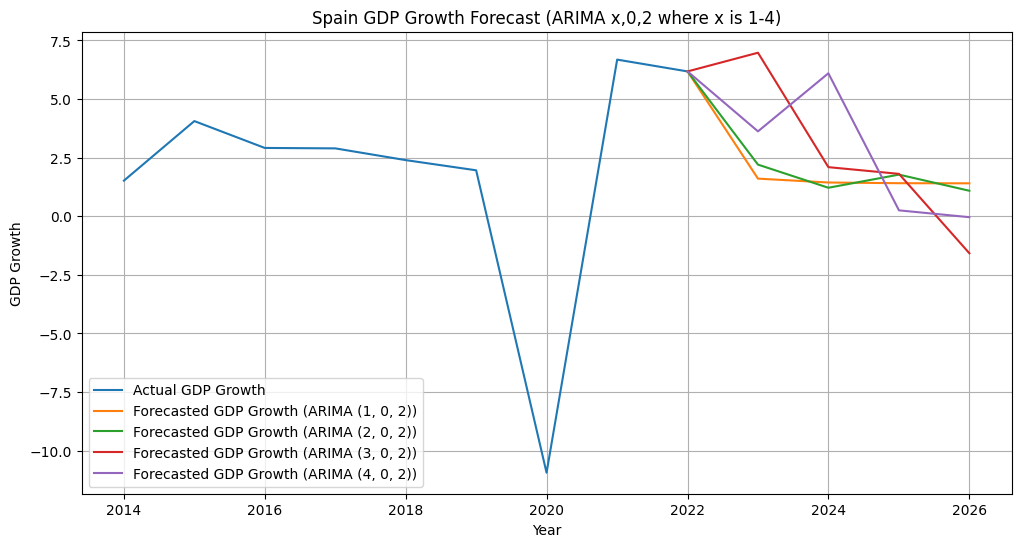

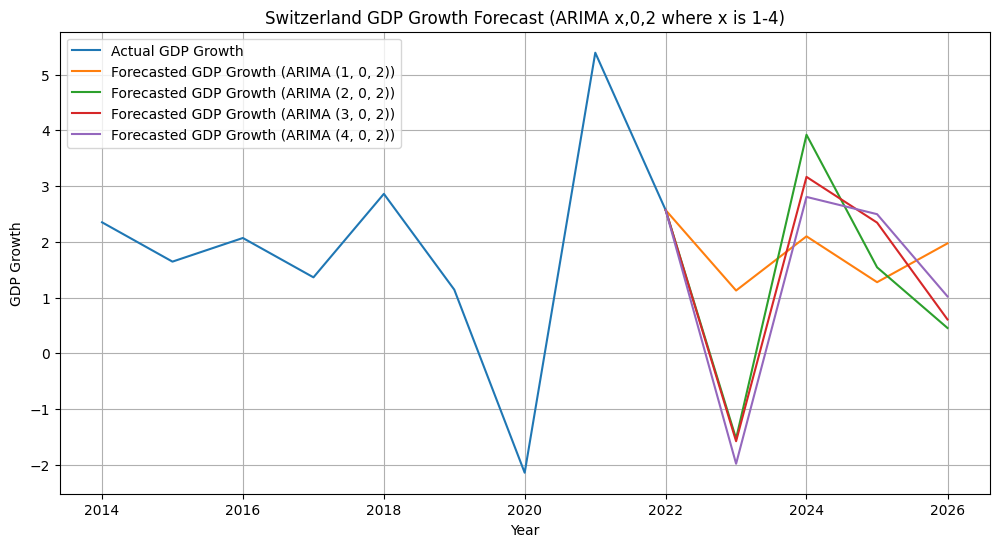

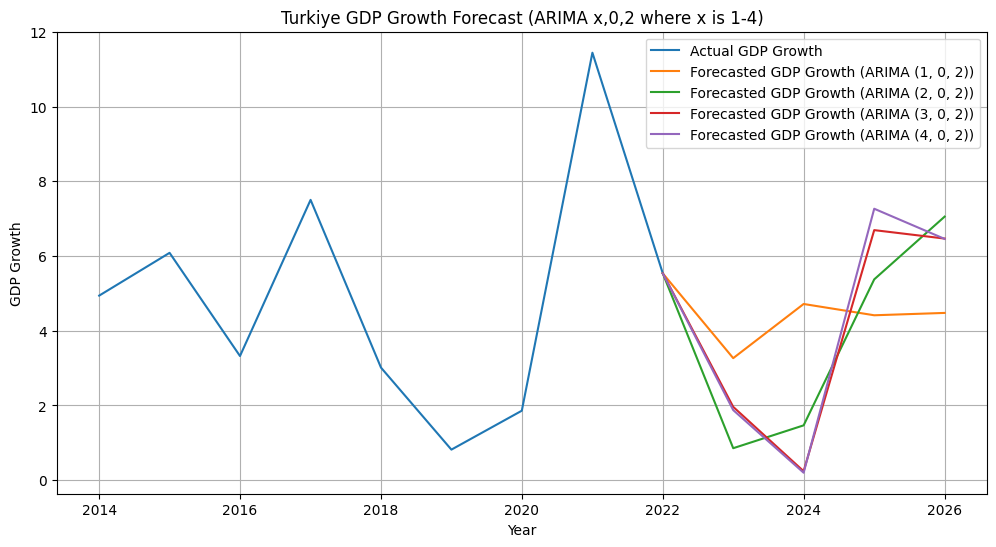

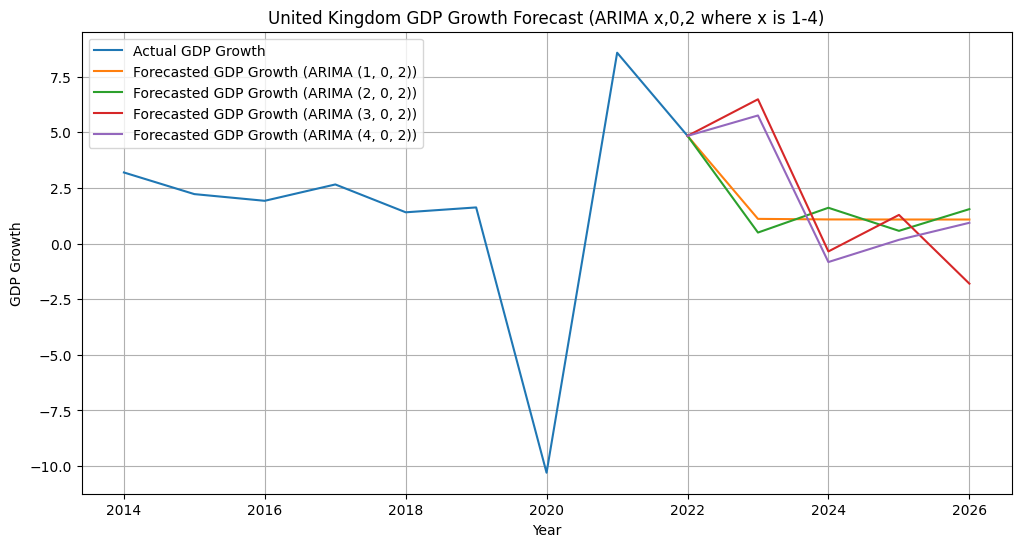

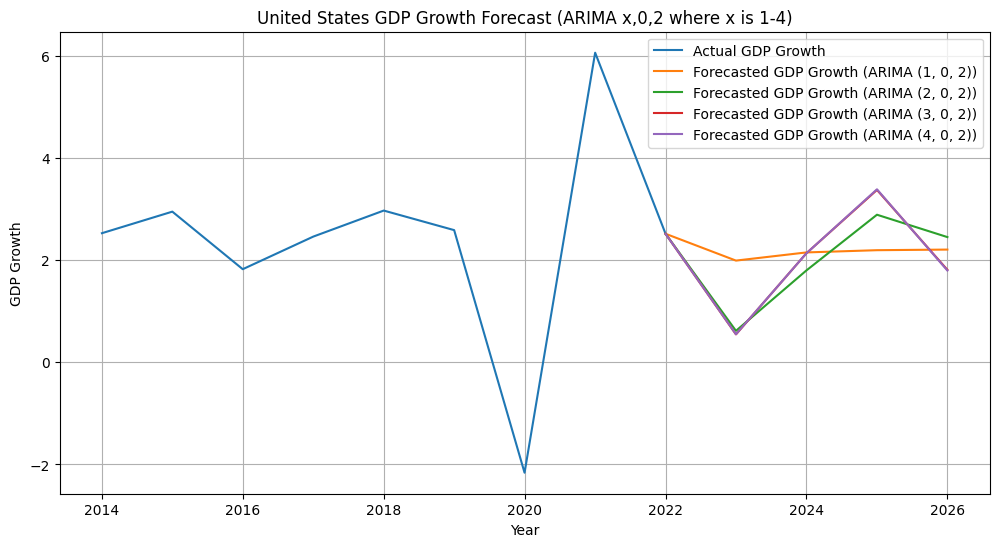

In [342]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

## Performing ARIMA Modeling & Prediction On Each Country Using df_cleaned data
## Create models and graph for lags 1 through 4

for country, country_df in country_dfs_HSS.items():
    if 'GDP_growth' in country_df.columns:
        try:
            country_gdp_growth = country_df[['Year', 'GDP_growth']].copy()
            country_gdp_growth['Year'] = pd.to_datetime(country_gdp_growth['Year'], format='%Y')
            country_gdp_growth.set_index('Year', inplace=True)
            country_gdp_growth = country_gdp_growth['GDP_growth']
            # Split data for training and testing
            train_size = int(len(country_gdp_growth) * 0.9)  # 90% training
            train, test = country_gdp_growth[:train_size], country_gdp_growth[train_size:]

            plt.figure(figsize=(12, 6))  # Create a single figure for all models
            plt.plot(country_gdp_growth, label='Actual GDP Growth')

            for x in range(1, 5):  # Iterate through x values (1 to 4)
                order = (x, 0, 2)
                try:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore")  # some combinations create errors.
                        model = ARIMA(train, order=order)
                        model_fit = model.fit()

                        # Calculate AIC and BIC
                        aic = model_fit.aic
                        bic = model_fit.bic

                        # Print model summary - Use For Analysis
                        '''
                        print(f"\nSummary for {country} ARIMA {order}:")
                        print(model_fit.summary())
                        '''
                        # Forecast using the model
                        forecast = model_fit.forecast(steps=5)
                        forecast = pd.Series(forecast).fillna(method='ffill')

                        # Create a date index for the forecast
                        last_date = country_gdp_growth.index[-1]
                        forecast_index = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=5, freq='YS')
                        forecast_series = pd.Series(forecast, index=forecast_index)

                       #print(f"Forecast for {country} GDP Growth (ARIMA {order}): {forecast_series} AIC is: {aic} BIC is {bic}")

                        # Combine actual and forecasted data for plotting
                        combined_data = pd.concat([country_gdp_growth, forecast_series])

                        plt.plot(combined_data[country_gdp_growth.index[-1]:], label=f'Forecasted GDP Growth (ARIMA {order})') #color is now default.

                except Exception as e:
                    # Handle exceptions (e.g., non-stationary data)
                    print(f"Error processing ARIMA {order} for {country}: {e}")

            plt.title(f'{country} GDP Growth Forecast (ARIMA x,0,2 where x is 1-4)')
            plt.xlabel('Year')
            plt.ylabel('GDP Growth')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error processing {country}: {e}")
    else:
        print(f"GDP_growth column not found for {country}")

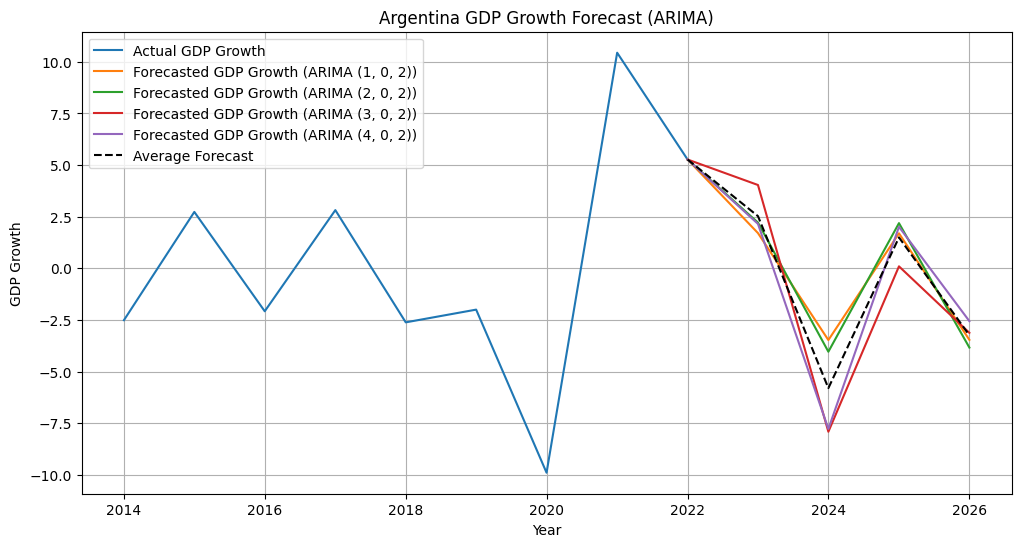

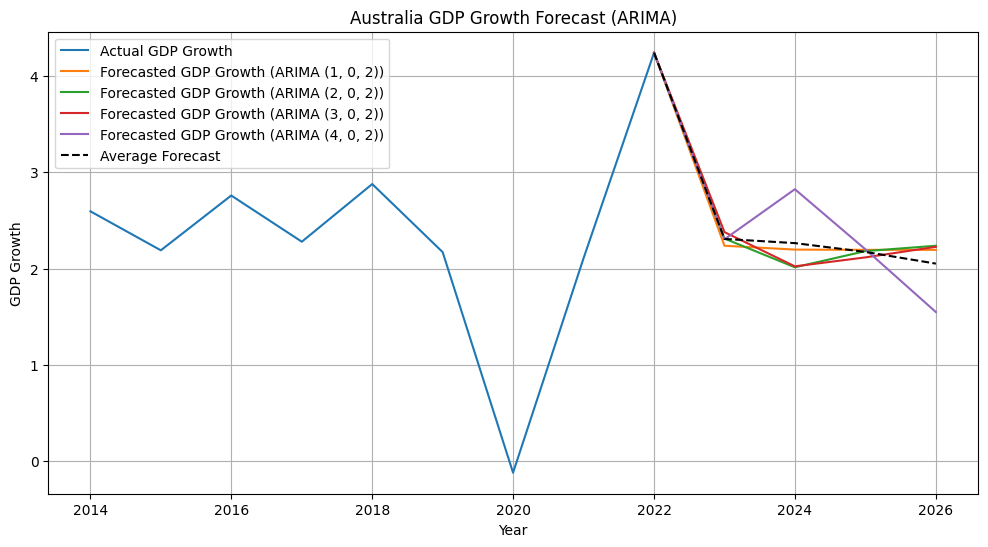

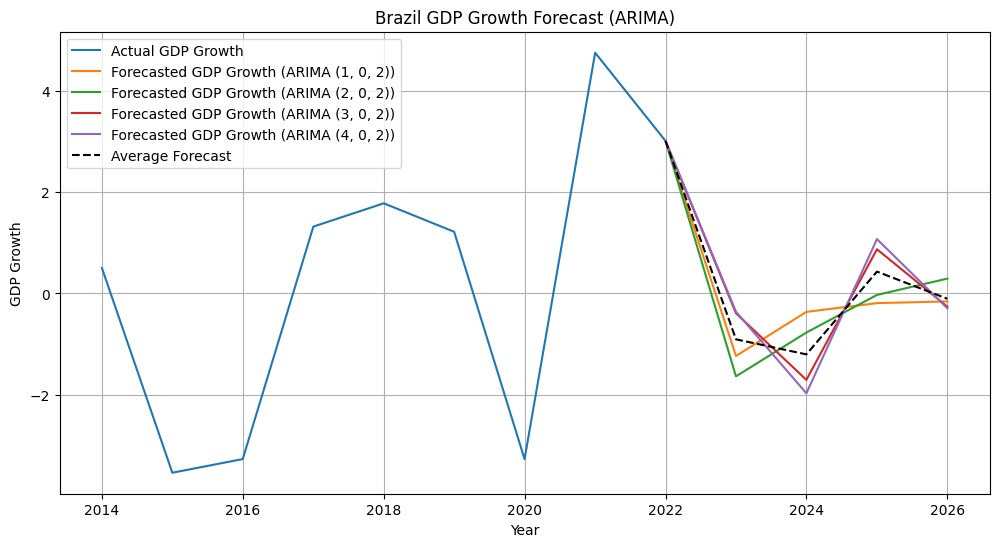

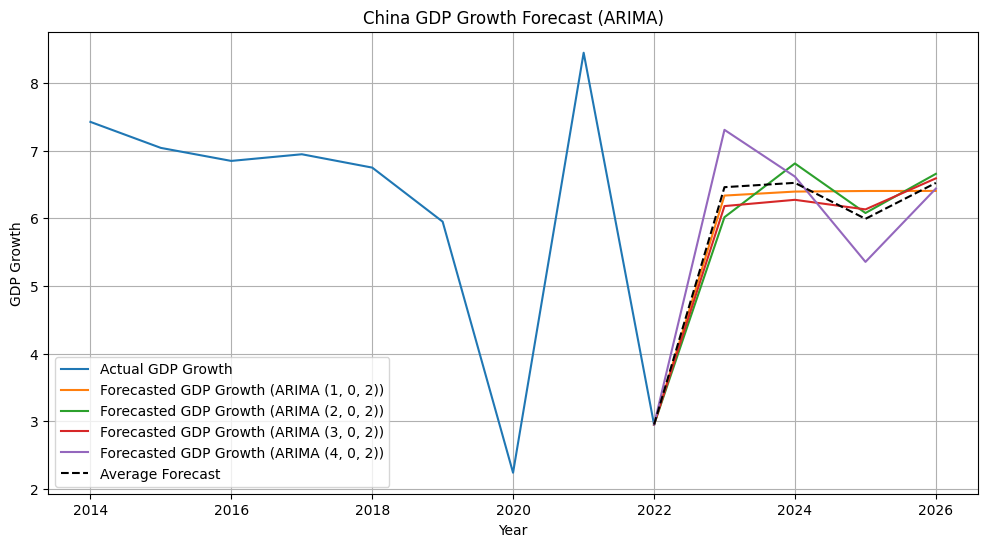

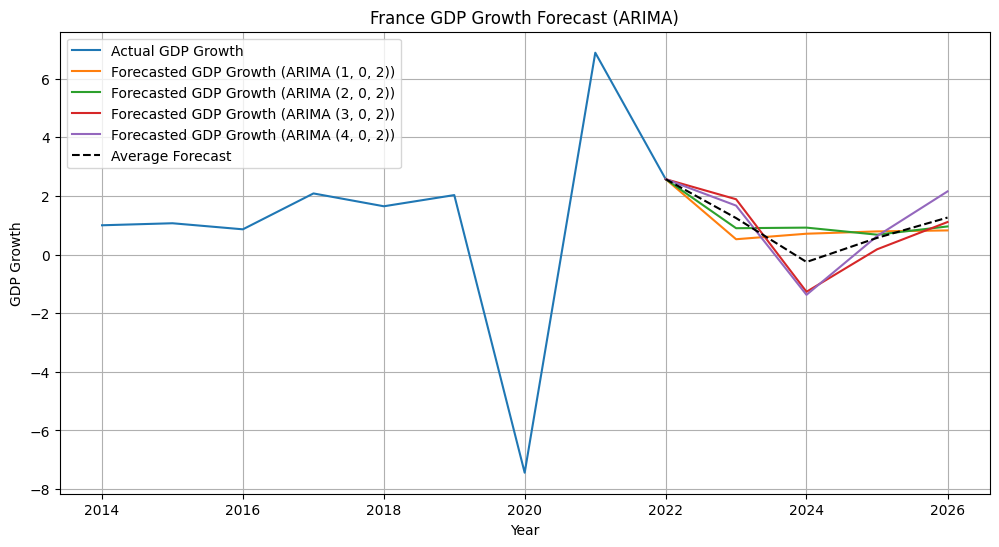

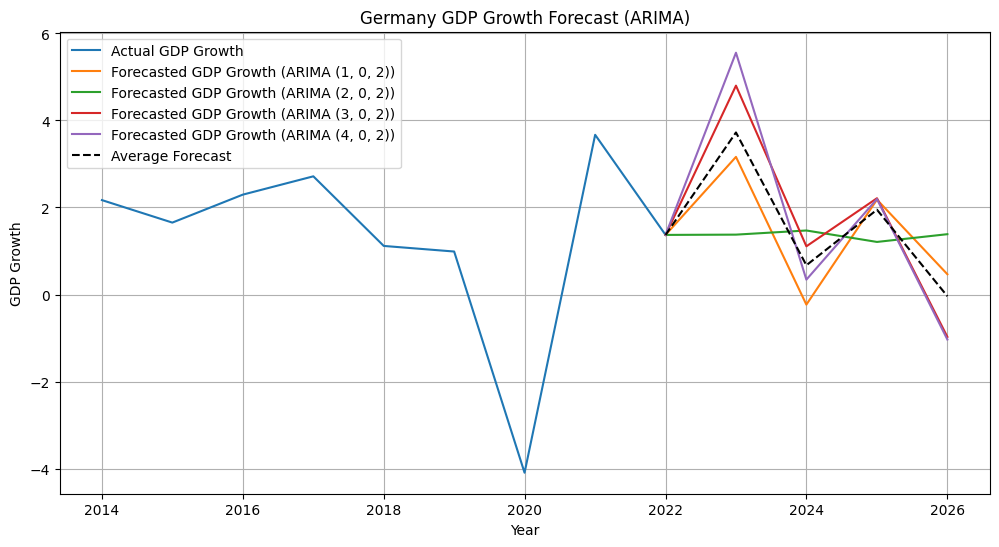

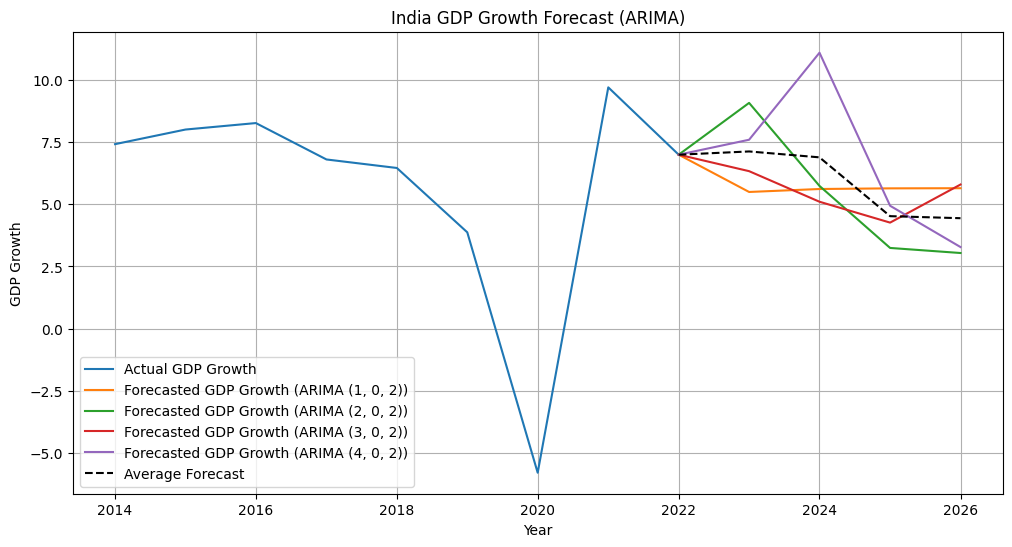

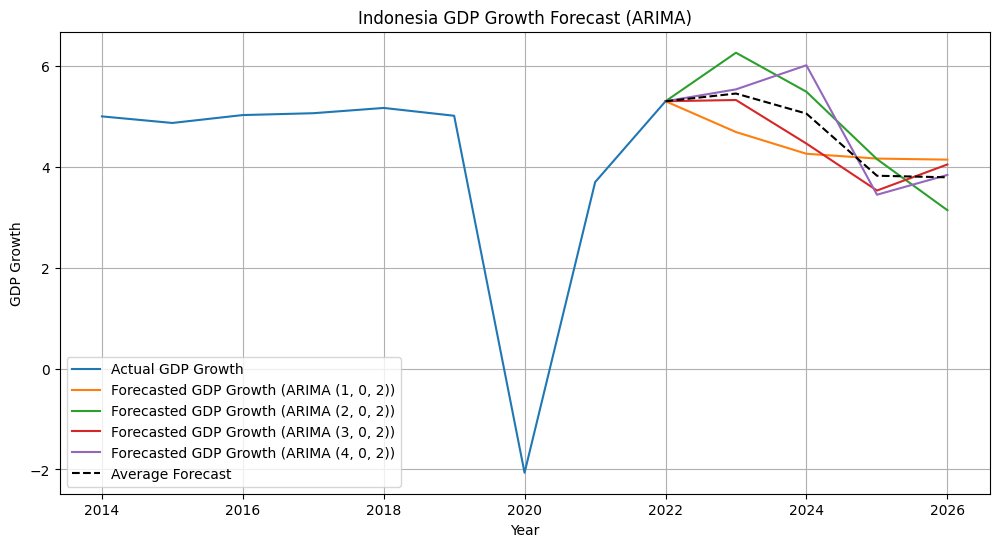

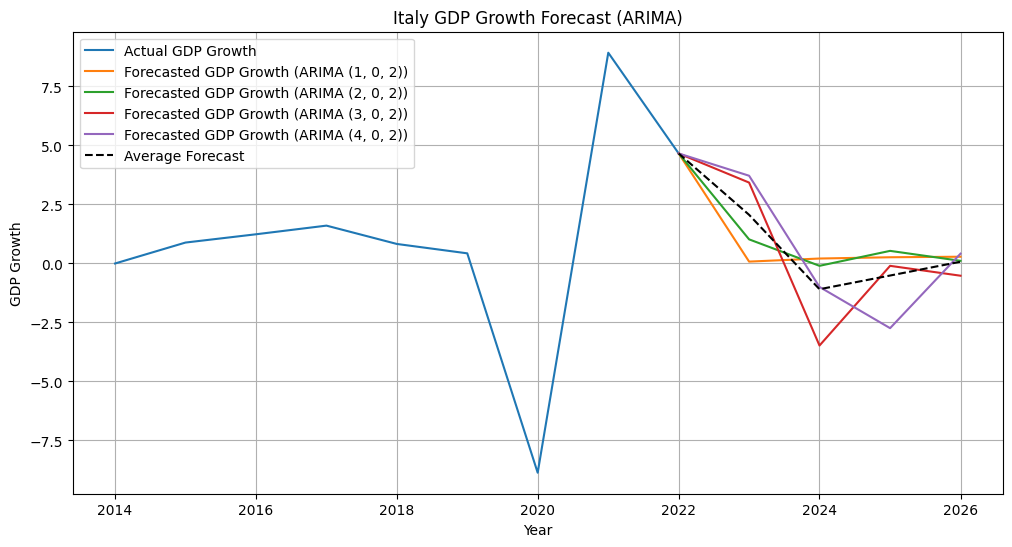

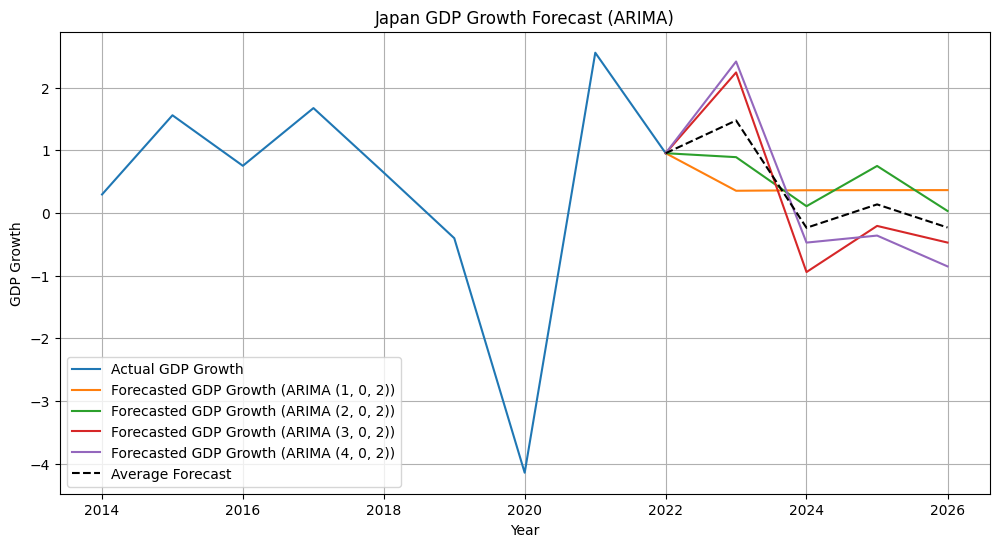

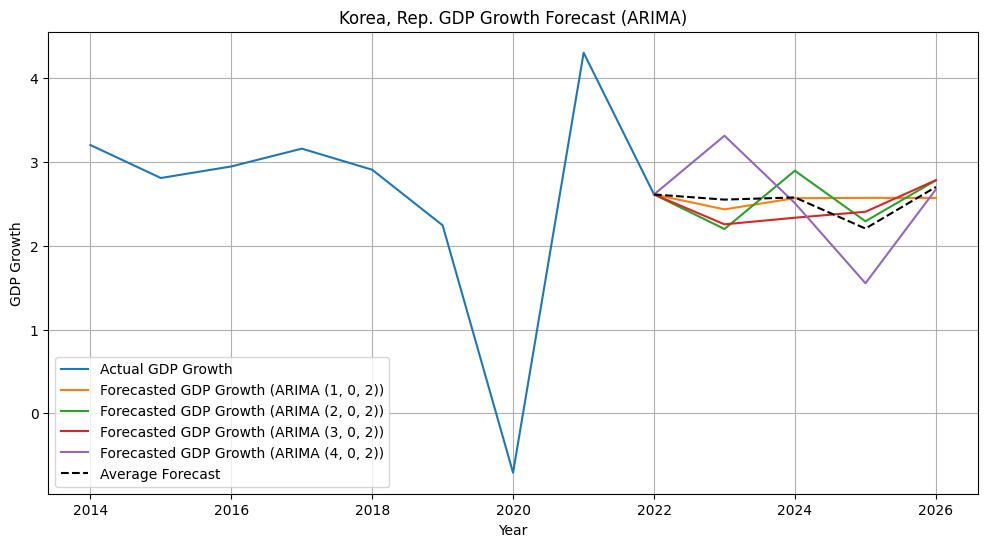

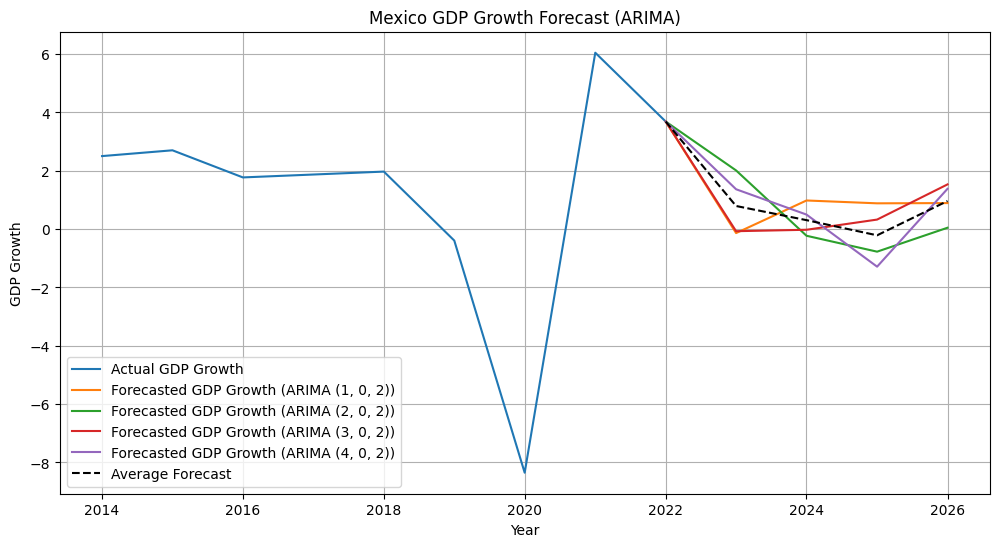

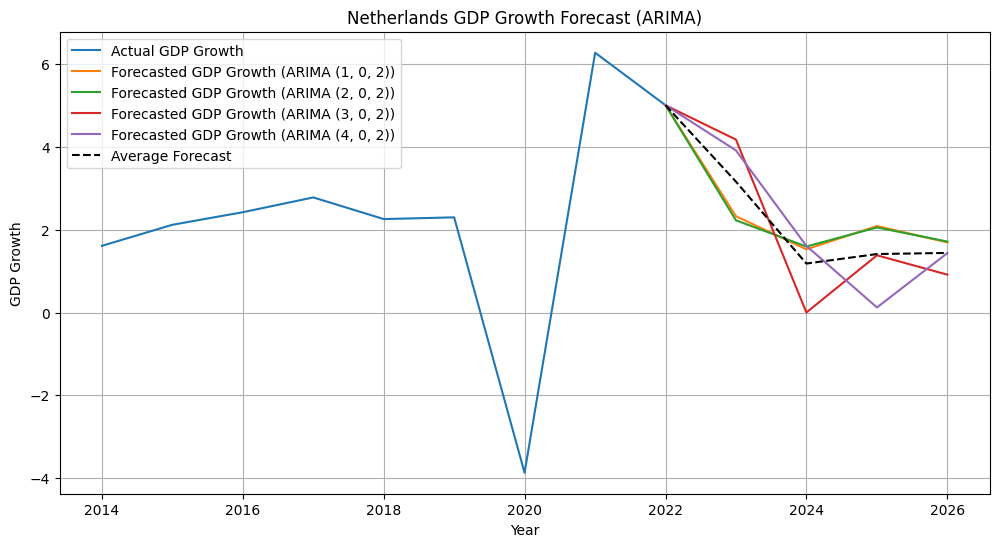

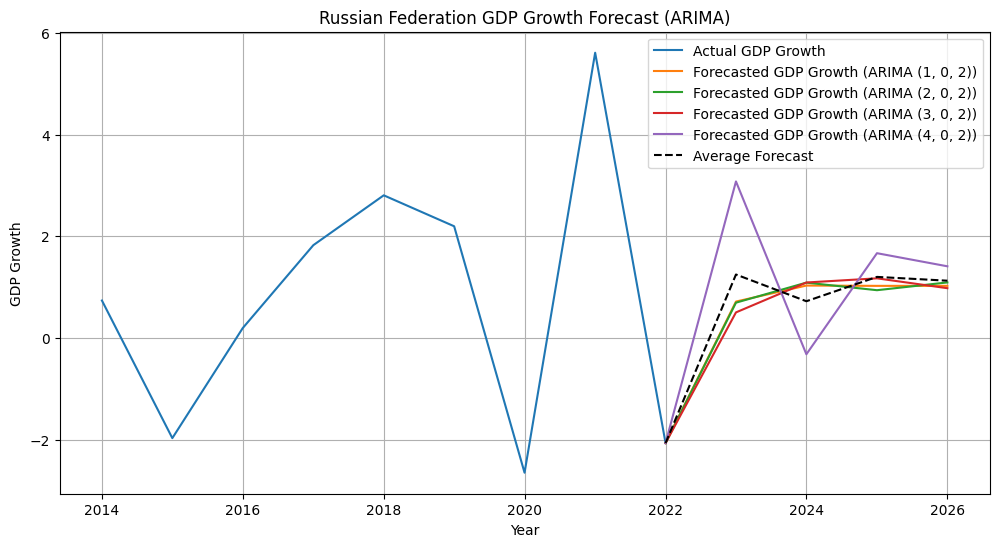

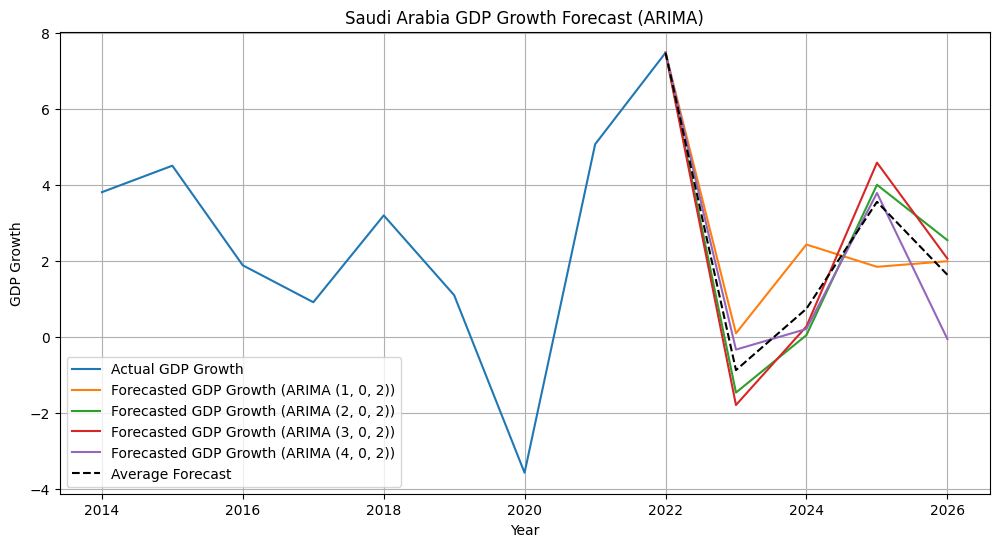

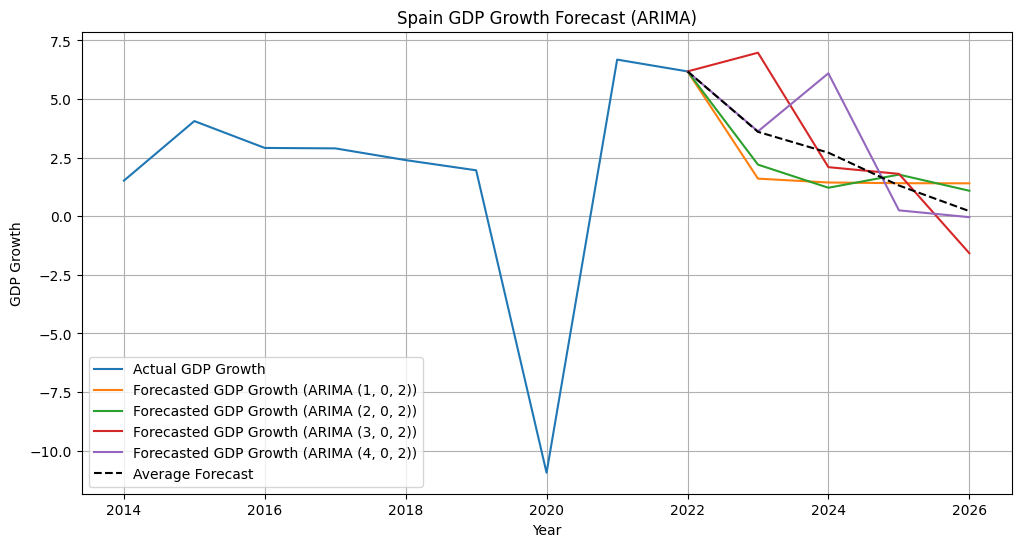

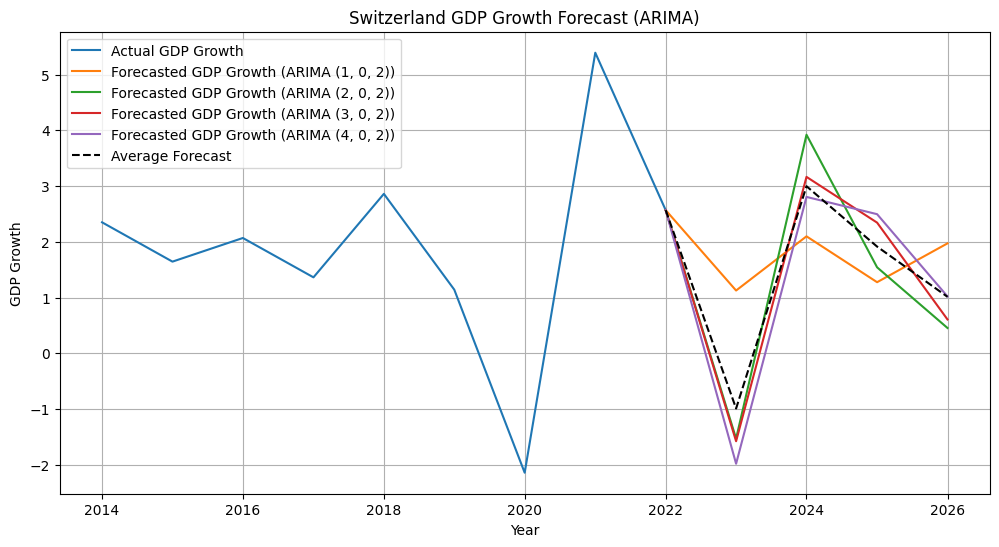

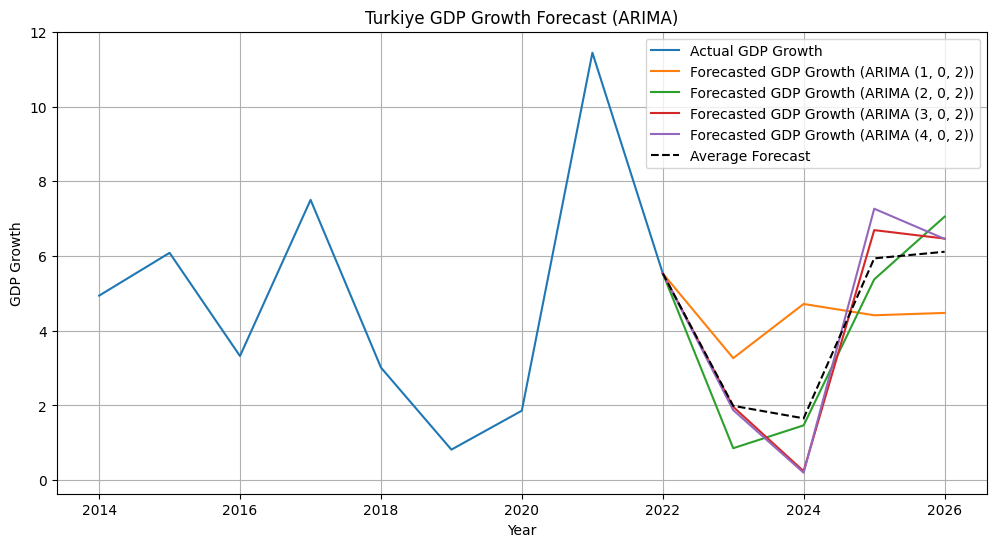

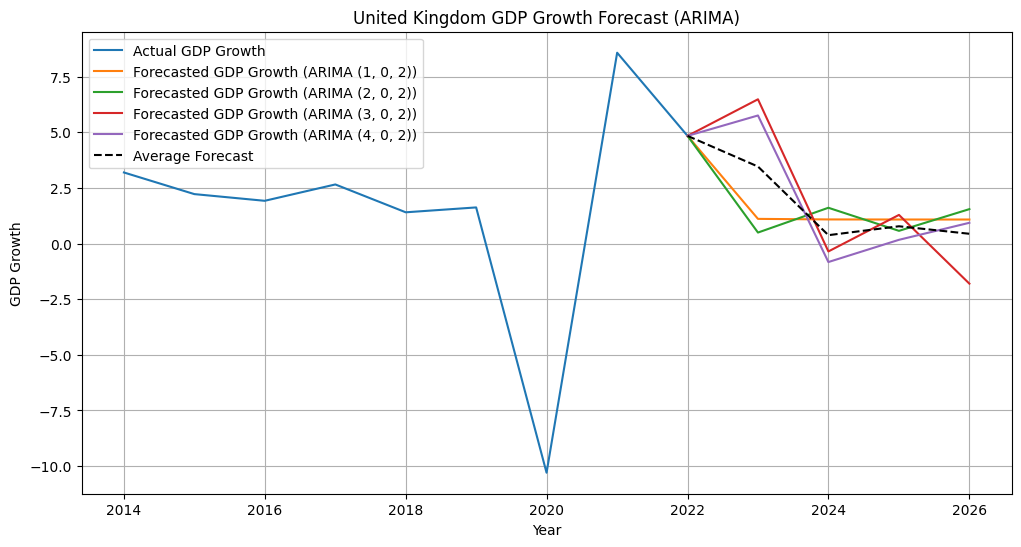

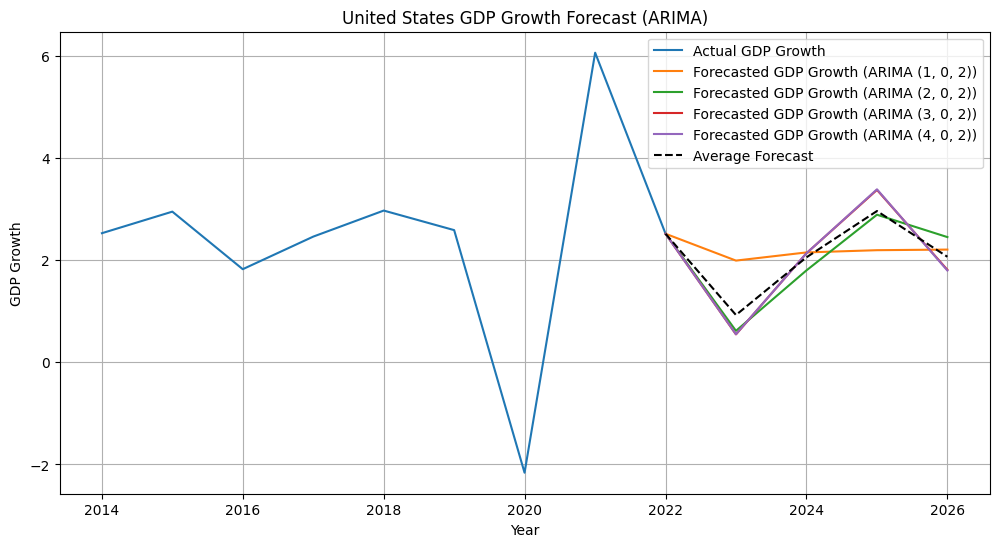

In [343]:

from statsmodels.tsa.arima.model import ARIMA
import warnings

## Running ARIMA With Only The Statistically Significant Features Identified By Earlier Regressions
## Create models and graph for lags 1 through 4

for country, country_df in country_dfs_HSS.items():
    if 'GDP_growth' in country_df.columns:
        try:
            country_gdp_growth = country_df[['Year', 'GDP_growth']].copy()
            country_gdp_growth['Year'] = pd.to_datetime(country_gdp_growth['Year'], format='%Y')
            country_gdp_growth.set_index('Year', inplace=True)
            country_gdp_growth = country_gdp_growth['GDP_growth']

            # Split data for training and testing
            train_size = int(len(country_gdp_growth) * 0.9)  # 90% training
            train, test = country_gdp_growth[:train_size], country_gdp_growth[train_size:]

            plt.figure(figsize=(12, 6))  # Create a single figure for all models
            plt.plot(country_gdp_growth, label='Actual GDP Growth')

            all_forecasts = []  # Store forecasts for each order

            for x in range(1, 5):  # Iterate through x values (1 to 4)
                order = (x, 0, 2)
                try:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore")  # some combinations create errors.
                        model = ARIMA(train, order=order)
                        model_fit = model.fit()

                        # Calculate AIC and BIC
                        aic = model_fit.aic
                        bic = model_fit.bic

                        # Print model summary - Use For Analysis
                        '''
                        print(f"\nSummary for {country} ARIMA {order}:")
                        print(model_fit.summary())
                        '''
                        # Forecast using the model
                        forecast = model_fit.forecast(steps=5)
                        forecast = pd.Series(forecast).fillna(method='ffill')

                        # Create a date index for the forecast
                        last_date = country_gdp_growth.index[-1]
                        forecast_index = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=5, freq='YS')
                        forecast_series = pd.Series(forecast, index=forecast_index)

                       #print(f"Forecast for {country} GDP Growth (ARIMA {order}): {forecast_series} AIC is: {aic} BIC is {bic}")

                        # Combine actual and forecasted data for plotting
                        combined_data = pd.concat([country_gdp_growth, forecast_series])

                        plt.plot(combined_data[country_gdp_growth.index[-1]:], label=f'Forecasted GDP Growth (ARIMA {order})') #color is now default.
                        all_forecasts.append(forecast_series)  # Store the forecast

                except Exception as e:
                    # Handle exceptions (e.g., non-stationary data)
                    print(f"Error processing ARIMA {order} for {country}: {e}")

            if all_forecasts:  # Check if any forecasts were generated
                # Calculate the average forecast
                average_forecast = pd.concat(all_forecasts, axis=1).mean(axis=1)

                # Connect average forecast to the last observed year
                last_observed_value = country_gdp_growth.iloc[-1]
                average_forecast_with_connection = pd.concat([pd.Series([last_observed_value], index=[country_gdp_growth.index[-1]]), average_forecast])

                plt.plot(average_forecast_with_connection, label='Average Forecast', color='black', linestyle='--')  # Plot the average

            plt.title(f'{country} GDP Growth Forecast (ARIMA)')
            plt.xlabel('Year')
            plt.ylabel('GDP Growth')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error processing {country}: {e}")
    else:
        print(f"GDP_growth column not found for {country}")
